## ETAPA 1: Carregamento Inicial e Diagnóstico do Dataset

Nesta etapa, será feito o carregamento do arquivo `dados_para_cura.csv` contendo os dados brutos organizados em colunas já nomeadas.

Objetivos:
- Verificar a estrutura geral da base;
- Quantificar colunas e linhas;
- Avaliar tipos de dados detectados pelo `pandas`;
- Identificar colunas com:
  - Valores nulos;
  - Valores constantes;
  - Registros duplicados.

Este diagnóstico servirá como base para definir os próximos passos da EDA.


In [3]:
# 🔧 ETAPA: Carregamento e Diagnóstico Inicial do Dataset

import pandas as pd

# Caminho para o dataset de trabalho
path = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura.csv"

# Leitura com separador correto
df = pd.read_csv(path, sep=";", low_memory=False)

# Diagnóstico geral
num_linhas, num_colunas = df.shape
tipos_dados = df.dtypes.value_counts()
nulos_por_coluna = df.isnull().sum()
constantes = df.nunique()[df.nunique() == 1]
duplicadas = df.duplicated().sum()

# Exibição dos resultados
print(f"✔️ Linhas: {num_linhas:,}")
print(f"✔️ Colunas: {num_colunas:,}")
print("\n📌 Tipos de dados detectados:\n", tipos_dados)
print("\n📌 Colunas com valores nulos:\n", nulos_por_coluna[nulos_por_coluna > 0])
print("\n📌 Colunas com valores constantes:\n", constantes)
print(f"\n📌 Linhas duplicadas: {duplicadas}")


✔️ Linhas: 21,840
✔️ Colunas: 152

📌 Tipos de dados detectados:
 float64    151
object       1
Name: count, dtype: int64

📌 Colunas com valores nulos:
 Unnamed: 1                            21840
flw_output_of_belt_coal_fdr_a1_t_h    21840
flw_output_of_belt_coal_fdr_a2_t_h    21840
flw_output_of_belt_coal_fdr_b1_t_h    21840
flw_output_of_belt_coal_fdr_b2_t_h    21840
                                      ...  
prs_of_condensate_pump_a_inlet_kpa    21840
prs_of_condensate_pump_b_inlet_kpa    21840
prs_of_condensate_pump_b_outl_mpa     21840
temp_of_cnd_pump_outl_header_adegc    21840
prs_of_cnd_pump_outl_header_mpa       21840
Length: 151, dtype: int64

📌 Colunas com valores constantes:
 Series([], dtype: int64)

📌 Linhas duplicadas: 3872


## ETAPA 2: Diagnóstico e Reconversão de Colunas Numéricas

Na etapa anterior, foram detectadas 151 colunas com 100% de valores nulos. No entanto, isso é tecnicamente improvável, pois sabemos que os arquivos originais CSV **contêm dados válidos**, muitas vezes registrados como **strings numéricas** ou com **caracteres inconsistentes** (ex: aspas, separadores incorretos).

Nesta etapa, realizaremos:

- Diagnóstico preciso das colunas com `dtype=object`;
- Tentativa de conversão de todas essas colunas para `float`, forçando coerção (`errors='coerce'`);
- Recontagem dos valores nulos;
- **Nenhuma coluna será excluída nesta etapa** — apenas tratadas para garantir consistência para as próximas análises.

Essa abordagem assegura que **nenhuma informação válida será perdida prematuramente**.


In [4]:
# 🔧 ETAPA: Diagnóstico e tentativa de reconversão de colunas mal interpretadas

import pandas as pd
from pathlib import Path

# (Re)carregar o arquivo original se necessário
path_raw = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura.csv")
df = pd.read_csv(path_raw, sep=";", encoding="utf-8")

# Diagnóstico inicial
colunas_obj = df.select_dtypes(include=["object"]).columns.tolist()
print(f"📌 Colunas inicialmente com tipo 'object': {len(colunas_obj)}")

# Tentar converter colunas object para float
for col in colunas_obj:
    try:
        df[col] = pd.to_numeric(df[col].str.replace(",", ".").str.replace('"', '').str.strip(), errors="coerce")
    except Exception as e:
        print(f"⚠️ Falha ao converter: {col} → {e}")

# Diagnóstico pós-conversão
nulos_por_coluna = df.isna().sum()
colunas_totalmente_nulas = nulos_por_coluna[nulos_por_coluna == df.shape[0]].index.tolist()

print(f"\n📌 Colunas que continuam com 100% de nulos após reconversão: {len(colunas_totalmente_nulas)}")
print(f"🧾 Exemplo: {colunas_totalmente_nulas[:10]}")

# Exportar versão convertida
saida_corrigida = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_convertido.csv")
df.to_csv(saida_corrigida, sep=";", index=False)
print(f"\n✅ Arquivo salvo em: {saida_corrigida}")


📌 Colunas inicialmente com tipo 'object': 1

📌 Colunas que continuam com 100% de nulos após reconversão: 152
🧾 Exemplo: ['Timestamp', 'Unnamed: 1', 'flw_output_of_belt_coal_fdr_a1_t_h', 'flw_output_of_belt_coal_fdr_a2_t_h', 'flw_output_of_belt_coal_fdr_b1_t_h', 'flw_output_of_belt_coal_fdr_b2_t_h', 'flw_output_of_belt_coal_fdr_b3_t_h', 'flw_output_of_belt_coal_fdr_b4_t_h', 'flw_output_of_belt_coal_fdr_c1_t_h', 'flw_output_of_belt_coal_fdr_c2_t_h']

✅ Arquivo salvo em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_convertido.csv


## ETAPA 3: Leitura Forçada Robusta com Parsing Manual

A leitura anterior falhou na recuperação dos dados — todas as colunas foram interpretadas como `NaN`, mesmo sabendo que os arquivos contêm valores válidos.

Nesta etapa, será feita uma **leitura alternativa do CSV com parsing mais tolerante**, ajustando:

- O motor de leitura para `engine='python'`;
- A supressão de tratamento de aspas com `quoting=csv.QUOTE_NONE`;
- A substituição de vírgulas por pontos;
- A análise amostral das 5 primeiras linhas **visualmente**, para validar a recuperação.

Essa abordagem é usada para recuperar estruturas de arquivos que têm problemas de formatação crônica, como delimitadores inconsistentes ou uso abusivo de aspas.


## ETAPA 3: Leitura Robusta Corrigida (sem low_memory)

Removemos o parâmetro `low_memory`, que não é aceito com o `engine="python"`. A leitura do CSV permanece robusta, com tolerância a aspas malformadas e linhas quebradas. Essa leitura visa recuperar corretamente os dados que estavam sendo lidos como `NaN` anteriormente.


In [6]:
# 🔧 ETAPA: Leitura alternativa robusta (sem low_memory)

import pandas as pd
import csv
from pathlib import Path

# Caminho do arquivo original
caminho = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura.csv")

# Leitura forçada ignorando aspas, engine mais tolerante (sem low_memory)
df = pd.read_csv(
    caminho,
    sep=";",
    encoding="utf-8",
    quoting=csv.QUOTE_NONE,
    engine="python",
    on_bad_lines="skip"
)

# Diagnóstico visual inicial
print(f"✔️ Linhas lidas: {df.shape[0]}")
print(f"✔️ Colunas detectadas: {df.shape[1]}")
print("\n📌 Amostra das 5 primeiras linhas:\n")
display(df.head())


✔️ Linhas lidas: 21840
✔️ Colunas detectadas: 152

📌 Amostra das 5 primeiras linhas:



Timestamp  Unnamed: 1 flw_output_of_belt_coal_fdr_a1_t_h  \
0  """06/29/2023 23:00:00         NaN                            36.421    
1  """06/29/2023 22:00:00         NaN                            37.313    
2  """06/29/2023 21:00:00         NaN                            36.787    
3  """06/29/2023 20:00:00         NaN                            37.313    
4  """06/29/2023 19:00:00         NaN                            36.910    

  flw_output_of_belt_coal_fdr_a2_t_h flw_output_of_belt_coal_fdr_b1_t_h  \
0                            34.168                             33.509    
1                            35.276                             35.290    
2                            34.471                             34.026    
3                            34.406                             34.535    
4                            35.473                             35.601    

  flw_output_of_belt_coal_fdr_b2_t_h flw_output_of_belt_coal_fdr_b3_t_h  \
0                            34.521                             29.797    
1                            35.711                             30.895    
2                            34.319                             30.895    
3                            34.901                             32.205    
4                            34.974                             32.791    

  flw_output_of_belt_coal_fdr_b4_t_h flw_output_of_belt_coal_fdr_c1_t_h  \
0                            32.795                             32.676    
1                            33.161                             32.621    
2                            32.955                             32.548    
3                            32.301                             32.260    
4                            32.841                             32.658    

  flw_output_of_belt_coal_fdr_c2_t_h  ... te_no_7_hp_heater_ol_feed_wtr_adegc  \
0                            32.603   ...                             254.181   
1                            33.509   ...                             254.628   
2                            32.713   ...                              254.88   
3                            31.976   ...                             254.433   
4                            32.736   ...                             253.986   

  te_no_6_hp_heater_ol_feed_wtr_adegc temp_of_4_lph_outl_wtr_adegc  \
0                             224.011                      151.055   
1                              224.46                      151.464   
2                             224.714                      151.873   
3                             224.264                      151.259   
4                             223.815                      151.055   

  temp_of_3_lph_outl_wtr_adegc prs_of_condensate_pump_a_outl_mpa  \
0                      114.222                             3.439   
1                      114.869                             3.381   
2                      115.354                             3.441   
3                      113.737                             3.495   
4                      114.707                             3.464   

  prs_of_condensate_pump_a_inlet_kpa prs_of_condensate_pump_b_inlet_kpa  \
0                           -72.340                            -70.775    
1                           -71.894                            -70.737    
2                           -71.688                            -70.229    
3                           -72.018                            -70.809    
4                           -72.461                            -70.991    

  prs_of_condensate_pump_b_outl_mpa temp_of_cnd_pump_outl_header_adegc  \
0                            -0.037                             33.596   
1                            -0.037                              34.03   
2                            -0.037                             33.951   
3                            -0.037                             33.833   
4                            -0.037                             33.9

## ETAPA 4: Limpeza Rigorosa de Strings Numéricas

O CSV original continha valores numéricos armazenados como **strings sujas**, com aspas duplicadas e espaços. Isso impediu a conversão para `float` e causou preenchimento incorreto com `NaN`. Vamos agora corrigir isso usando um processo robusto de limpeza e conversão.


In [7]:
# 🔧 ETAPA: Limpeza de strings numéricas e conversão para float

import pandas as pd
import numpy as np
from pathlib import Path

# Caminho original do arquivo
caminho = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura.csv")

# Leitura robusta, ignorando aspas problemáticas
df = pd.read_csv(
    caminho,
    sep=";",
    encoding="utf-8",
    quoting=csv.QUOTE_NONE,
    engine="python",
    on_bad_lines="skip"
)

# Função de limpeza por coluna
def limpar_valor(x):
    if pd.isna(x):
        return np.nan
    x = str(x)
    x = x.replace('"', '')        # remove todas as aspas
    x = x.replace("'", '')        # remove aspas simples (caso raro)
    x = x.strip()                 # remove espaços em excesso
    return x

# Aplica limpeza em todas as colunas (exceto Timestamp)
for col in df.columns[1:]:  # preserva a coluna Timestamp original
    df[col] = df[col].apply(limpar_valor)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Corrige timestamp também
df['Timestamp'] = df['Timestamp'].astype(str).str.replace('"', '').str.strip()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce', dayfirst=False)

# Diagnóstico pós-conversão
print("📌 Tipos após limpeza:")
print(df.dtypes.value_counts())

print("\n📌 Amostra pós-limpeza:")
display(df.head(3))

# Salva resultado
saida = caminho.with_name("dados_para_cura_limpo.csv")
df.to_csv(saida, sep=";", index=False)
print(f"\n✅ Arquivo salvo em: {saida}")


📌 Tipos após limpeza:
float64           151
datetime64[ns]      1
Name: count, dtype: int64

📌 Amostra pós-limpeza:


Timestamp  Unnamed: 1  flw_output_of_belt_coal_fdr_a1_t_h  \
0 2023-06-29 23:00:00         NaN                              36.421   
1 2023-06-29 22:00:00         NaN                              37.313   
2 2023-06-29 21:00:00         NaN                              36.787   

   flw_output_of_belt_coal_fdr_a2_t_h  flw_output_of_belt_coal_fdr_b1_t_h  \
0                              34.168                              33.509   
1                              35.276                              35.290   
2                              34.471                              34.026   

   flw_output_of_belt_coal_fdr_b2_t_h  flw_output_of_belt_coal_fdr_b3_t_h  \
0                              34.521                              29.797   
1                              35.711                              30.895   
2                              34.319                              30.895   

   flw_output_of_belt_coal_fdr_b4_t_h  flw_output_of_belt_coal_fdr_c1_t_h  \
0                              32.795                              32.676   
1                              33.161                              32.621   
2                              32.955                              32.548   

   flw_output_of_belt_coal_fdr_c2_t_h  ...  \
0                              32.603  ...   
1                              33.509  ...   
2                              32.713  ...   

   te_no_7_hp_heater_ol_feed_wtr_adegc  te_no_6_hp_heater_ol_feed_wtr_adegc  \
0                              254.181                              224.011   
1                              254.628                              224.460   
2                              254.880                              224.714   

   temp_of_4_lph_outl_wtr_adegc  temp_of_3_lph_outl_wtr_adegc  \
0                       151.055                       114.222   
1                       151.464                       114.869   
2                       151.873                       115.354   

   prs_of_condensate_pump_a_outl_mpa  prs_of_condensate_pump_a_inlet_kpa  \
0                              3.439                             -72.340   
1                              3.381                             -71.894   
2                              3.441                             -71.688   

   prs_of_condensate_pump_b_inlet_kpa  prs_of_condensate_pump_b_outl_mpa  \
0                             -70.775                             -0.037   
1                             -70.737                             -0.037   
2                             -70.229                             -0.037   

   temp_of_cnd_pump_outl_header_adegc  prs_of_cnd_pump_outl_header_mpa  
0                              33.596                            3.411  
1                              34.030                            3.352  
2                              33.951                            3.412  

[3 rows x 152 columns]


✅ Arquivo salvo em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_limpo.csv


## 📘 ETAPA: Análise Detalhada de Valores Ausentes por Coluna

Nesta etapa da EDA (Análise Exploratória de Dados), o foco é mapear e quantificar os valores ausentes (nulos) em cada coluna do dataset técnico da caldeira CFB.

A análise será dividida em três categorias, com base na **proporção de dados ausentes** por coluna:

- **Colunas Completas**: 100% preenchidas.
- **Parcialmente Incompletas**: até 50% de valores ausentes.
- **Altamente Incompletas**: mais de 50% de valores ausentes.

Esse diagnóstico será essencial para:

- Avaliar a qualidade de cada variável.
- Tomar decisões futuras sobre imputação, exclusão ou tratamento customizado.
- Planejar a consistência e a robustez dos modelos preditivos futuros (ML/DL).

O resultado será apresentado em uma tabela interativa, com o número absoluto e percentual de nulos por variável.


📄 ETAPA A1 — Seleção e leitura canônica do arquivo limpo
Nesta etapa, vamos garantir que o dataset utilizado na análise de nulos seja o arquivo correto já limpo (dados_para_cura_limpo.csv).
O objetivo é validar:

Existência do arquivo;

Estrutura básica (shape e colunas iniciais);

Tipos de dados detectados automaticamente;

Presença e integridade da coluna Timestamp.

Nenhuma modificação será feita nos dados neste passo.

In [42]:
# 🔍 ETAPA A1: LEITURA DO ARQUIVO LIMPO

import pandas as pd
from pathlib import Path

# Caminho para o arquivo limpo
CAMINHO_LIMPO = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_limpo.csv")

# 1. Verificar existência
assert CAMINHO_LIMPO.exists(), f"Arquivo não encontrado: {CAMINHO_LIMPO}"

# 2. Leitura canônica sem coerções arriscadas
df = pd.read_csv(
    CAMINHO_LIMPO,
    sep=";",
    encoding="utf-8",
    dtype_backend="numpy_nullable",  # preserva floats como Float64
    low_memory=False
)

# 3. Inspeção básica
print("Shape:", df.shape)
print("Colunas (primeiras 20):", list(df.columns[:20]))
print("\nTipos por coluna (amostra):")
print(df.dtypes.head(20))

# 4. Checar Timestamp
assert "Timestamp" in df.columns, "Coluna 'Timestamp' não encontrada no arquivo limpo."
print("\nAmostra de Timestamp:")
print(df["Timestamp"].head(5))


Shape: (21840, 151)
Colunas (primeiras 20): ['Timestamp', 'flw_output_of_belt_coal_fdr_a1_t_h', 'flw_output_of_belt_coal_fdr_a2_t_h', 'flw_output_of_belt_coal_fdr_b1_t_h', 'flw_output_of_belt_coal_fdr_b2_t_h', 'flw_output_of_belt_coal_fdr_b3_t_h', 'flw_output_of_belt_coal_fdr_b4_t_h', 'flw_output_of_belt_coal_fdr_c1_t_h', 'flw_output_of_belt_coal_fdr_c2_t_h', 'porcentagem_de_ar_primario_', 'upper_perc_do_ar_total_', 'burner_perc_do_ar_total_', 'lower_perc_do_ar_total_', 'coal_perc_do_ar_total_', 'temp_1_of_furnace_a_inner_adegc', 'pressure_of_furnace_a_lower_kpa', 'pressure_1_of_furnace_a_bed_kpa', 'pressure_3_of_furnace_bed_kpa', 'press_2_3_of_furnace_b_bed_kpa', 'pressure_1_of_furnace_b_bed_kpa']

Tipos por coluna (amostra):
Timestamp                             string[python]
flw_output_of_belt_coal_fdr_a1_t_h           Float64
flw_output_of_belt_coal_fdr_a2_t_h           Float64
flw_output_of_belt_coal_fdr_b1_t_h           Float64
flw_output_of_belt_coal_fdr_b2_t_h           Float6

📄 ETAPA A1 — Diagnóstico de nulos por coluna (arquivo limpo)
Nesta etapa, vamos:

Calcular a contagem absoluta e a proporção de nulos para cada coluna;

Ordenar da maior para a menor proporção de nulos;

Obter visão geral para guiar a decisão sobre tratamento de dados ausentes.

Não serão removidas colunas ou linhas neste passo.

In [43]:
# 🔍 ETAPA A1: DIAGNÓSTICO DE NULOS POR COLUNA

total_linhas = len(df)

nulos_abs = df.isna().sum()
nulos_prop = (nulos_abs / total_linhas).round(6)

nulos_df = (
    pd.DataFrame({
        "coluna": df.columns,
        "nulos": nulos_abs.values,
        "proporcao": nulos_prop.values
    })
    .sort_values(["proporcao", "nulos", "coluna"], ascending=[False, False, True])
    .reset_index(drop=True)
)

print("Visão geral de nulos (top 20 colunas com mais nulos):")
print(nulos_df.head(20))

print("\nResumo geral:")
print(f"- Linhas totais: {total_linhas}")
print(f"- Colunas totais: {df.shape[1]}")
print(f"- Colunas sem nenhum nulo: {(nulos_abs == 0).sum()}")
print(f"- Colunas com nulos parciais (0% < nulos < 100%): {((nulos_abs > 0) & (nulos_abs < total_linhas)).sum()}")
print(f"- Colunas com 100% nulos: {(nulos_abs == total_linhas).sum()}")


Visão geral de nulos (top 20 colunas com mais nulos):
                                coluna  nulos  proporcao
0                  point_not_found_nan  21840   1.000000
1                point_not_found_nan.1  13433   0.615064
2              upper_perc_do_ar_total_   8835   0.404533
3      prs_of_cnd_pump_outl_header_mpa   8736   0.400000
4   prs_of_gas_in_ecmz_side_a_outl_kpa   8736   0.400000
5        bed_temperature_average_adegc   5839   0.267353
6                total_air_flow_knm3_h   4745   0.217262
7   aph_main_motor_phase_w_current_nan   4706   0.215476
8   aph_main_motor_phase_u_current_nan   3925   0.179716
9   flw_output_of_belt_coal_fdr_b3_t_h   3623   0.165888
10  flw_output_of_belt_coal_fdr_b1_t_h   3598   0.164744
11  flw_output_of_belt_coal_fdr_a2_t_h   3553   0.162683
12  flw_output_of_belt_coal_fdr_a1_t_h   3514   0.160897
13       1_lms_pdr_bin_continous_lvl_m   3421   0.156639
14  flw_output_of_belt_coal_fdr_b4_t_h   3408   0.156044
15  flw_output_of_belt_coal_fdr_c1

📄 ETAPA A1 — Remoção de colunas com alta proporção de nulos (≥ 40%)
Nesta etapa, eliminaremos as colunas que apresentam 40% ou mais de valores nulos, pois têm baixa utilidade na modelagem e podem comprometer análises estatísticas.
O corte de 0,40 (40%) foi definido com base na inspeção anterior.

Antes de excluir:

A lista de colunas a remover será exibida para conferência;

A remoção será aplicada diretamente no df atual;

Será apresentado o novo shape do dataset após a operação.

In [44]:
# 🔧 ETAPA A1: REMOÇÃO DE COLUNAS COM >= 40% DE NULOS

# Identificar colunas com proporção de nulos >= 0.40
cols_remover = nulos_df.loc[nulos_df["proporcao"] >= 0.40, "coluna"].tolist()

print(f"Total de colunas a remover: {len(cols_remover)}")
print("Colunas a remover:", cols_remover)

# Remover do dataframe
df = df.drop(columns=cols_remover)

# Verificar novo shape
print("\nNovo shape após remoção:", df.shape)


Total de colunas a remover: 5
Colunas a remover: ['point_not_found_nan', 'point_not_found_nan.1', 'upper_perc_do_ar_total_', 'prs_of_cnd_pump_outl_header_mpa', 'prs_of_gas_in_ecmz_side_a_outl_kpa']

Novo shape após remoção: (21840, 146)


📄 ETAPA A1 — Identificação de colunas object que parecem numéricas
Nesta etapa, vamos:

Localizar colunas do tipo object no dataframe atual;

Aplicar uma heurística para verificar se o conteúdo é numérico, mesmo que armazenado como string;

Produzir uma lista dessas colunas “suspeitas” para conversão controlada.

Não faremos conversões neste passo — apenas diagnóstico.

In [45]:
# 🔍 ETAPA A1: IDENTIFICAÇÃO DE COLUNAS OBJECT NUMÉRICAS

# 1. Localizar colunas object
cols_object = df.select_dtypes(include=["object", "string"]).columns.tolist()
print(f"Total de colunas object/string: {len(cols_object)}")

# 2. Função de verificação
def parece_numerico_heuristico(s, amostra=200):
    amostral = s.dropna().astype(str).str.strip().str.replace(",", ".", regex=False).head(amostra)
    if amostral.empty:
        return False
    try:
        pd.to_numeric(amostral, errors="raise")
        return True
    except Exception:
        return False

# 3. Aplicar heurística
suspeitas_numericas = [c for c in cols_object if parece_numerico_heuristico(df[c])]

print(f"Colunas object que parecem numéricas: {suspeitas_numericas}")


Total de colunas object/string: 1
Colunas object que parecem numéricas: []


📄 ETAPA A1 — Conversão segura da coluna Timestamp para datetime
Nesta etapa:

Converteremos Timestamp para o tipo datetime64[ns];

Validaremos se a conversão ocorreu sem erros;

Manteremos o índice original, sem alteração de ordenação neste momento.

In [46]:
# 🔧 ETAPA A1: CONVERSÃO DO TIMESTAMP PARA DATETIME

# Conversão segura
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce", format="%Y-%m-%d %H:%M:%S")

# Checar se houve alguma conversão inválida
nulos_timestamp = df["Timestamp"].isna().sum()
print(f"Registros com Timestamp inválido após conversão: {nulos_timestamp}")

# Amostra para conferência
print(df["Timestamp"].head(10))
print(df["Timestamp"].dtypes)


Registros com Timestamp inválido após conversão: 0
0   2023-06-29 23:00:00
1   2023-06-29 22:00:00
2   2023-06-29 21:00:00
3   2023-06-29 20:00:00
4   2023-06-29 19:00:00
5   2023-06-29 18:00:00
6   2023-06-29 17:00:00
7   2023-06-29 16:00:00
8   2023-06-29 15:00:00
9   2023-06-29 14:00:00
Name: Timestamp, dtype: datetime64[ns]
datetime64[ns]


📄 ETAPA A1 — Verificação da integridade temporal do Timestamp
Nesta etapa:

Ordenaremos temporariamente os dados pelo Timestamp;

Checaremos duplicatas;

Calcularemos o intervalo mais frequente entre registros;

Apresentaremos estatísticas sobre a série temporal.

In [47]:
# 🔍 ETAPA A1: INTEGRIDADE TEMPORAL DO TIMESTAMP

# 1. Ordenar temporariamente por segurança
df_sorted = df.sort_values("Timestamp").reset_index(drop=True)

# 2. Contar duplicatas
duplicatas = df_sorted["Timestamp"].duplicated().sum()

# 3. Calcular diferenças de tempo entre registros consecutivos
deltas = df_sorted["Timestamp"].diff().dropna()

# 4. Frequência mais comum de intervalo
freq_comum = deltas.value_counts().head(1)

print(f"Total de registros duplicados no Timestamp: {duplicatas}")
print("\nIntervalo de tempo mais comum entre registros:")
print(freq_comum)

print("\nAmostra de diferenças de tempo:")
print(deltas.head(10))


Total de registros duplicados no Timestamp: 4392

Intervalo de tempo mais comum entre registros:
Timestamp
0 days 01:00:00    17444
Name: count, dtype: int64

Amostra de diferenças de tempo:
1    0 days 01:00:00
2    0 days 01:00:00
3    0 days 01:00:00
4    0 days 01:00:00
5    0 days 01:00:00
6    0 days 01:00:00
7    0 days 01:00:00
8    0 days 01:00:00
9    0 days 01:00:00
10   0 days 01:00:00
Name: Timestamp, dtype: timedelta64[ns]


📄 ETAPA A1 — Diagnóstico das duplicatas no Timestamp
Nesta etapa:

Filtraremos todos os timestamps duplicados;

Compararemos valores para identificar se são registros idênticos ou não;

Geraremos estatísticas sobre a diferença entre os duplicados.





In [48]:
# 🔍 ETAPA A1: ANÁLISE DAS DUPLICATAS NO TIMESTAMP

# 1. Filtrar duplicatas (mantendo todas as ocorrências)
df_dups = df[df["Timestamp"].duplicated(keep=False)]

print(f"Total de linhas com Timestamp duplicado: {len(df_dups)}")

# 2. Checar se existem duplicatas exatas (todos os campos iguais)
duplicatas_exatas = df_dups.duplicated(keep=False).sum()

print(f"Registros duplicados com todas as colunas iguais: {duplicatas_exatas}")

# 3. Amostra de casos com mesmo Timestamp mas valores diferentes
exemplo_diff = (
    df_dups.groupby("Timestamp")
    .filter(lambda x: len(x) > 1 and not x.duplicated(keep=False).all())
    .head(10)
)

print("\nAmostra de duplicatas não idênticas:")
print(exemplo_diff)


Total de linhas com Timestamp duplicado: 8784
Registros duplicados com todas as colunas iguais: 8784

Amostra de duplicatas não idênticas:
Empty DataFrame
Columns: [Timestamp, flw_output_of_belt_coal_fdr_a1_t_h, flw_output_of_belt_coal_fdr_a2_t_h, flw_output_of_belt_coal_fdr_b1_t_h, flw_output_of_belt_coal_fdr_b2_t_h, flw_output_of_belt_coal_fdr_b3_t_h, flw_output_of_belt_coal_fdr_b4_t_h, flw_output_of_belt_coal_fdr_c1_t_h, flw_output_of_belt_coal_fdr_c2_t_h, porcentagem_de_ar_primario_, burner_perc_do_ar_total_, lower_perc_do_ar_total_, coal_perc_do_ar_total_, temp_1_of_furnace_a_inner_adegc, pressure_of_furnace_a_lower_kpa, pressure_1_of_furnace_a_bed_kpa, pressure_3_of_furnace_bed_kpa, press_2_3_of_furnace_b_bed_kpa, pressure_1_of_furnace_b_bed_kpa, pressure_of_furnace_b_lower_kpa, temp_1_of_furnace_b_inner_adegc, furnace_bed_temp_1_3_sel_adegc, furnace_bed_temp_10_12_sel_adegc, furnace_bed_temp_4_6_sel_adegc, furnace_bed_temp_13_15_sel_adegc, furnace_bed_temp_7_9_sel_adegc, furnace

📄 ETAPA A1 — Remoção controlada de duplicatas exatas (manter primeira ocorrência)
Nesta etapa:

Vamos remover apenas as segundas ocorrências das duplicatas exatas no Timestamp;

Garantiremos que cada valor de Timestamp apareça no máximo uma vez;

Confirmaremos o novo tamanho do dataset e a ausência de duplicatas.

In [49]:
# 🔧 ETAPA A1: REMOÇÃO DE DUPLICATAS EXATAS (MANTENDO A PRIMEIRA)

# Remover duplicatas mantendo a primeira ocorrência
df = df.drop_duplicates(keep="first")

# Confirmar resultado
print("Novo shape:", df.shape)
print("Duplicatas restantes no Timestamp:", df["Timestamp"].duplicated().sum())


Novo shape: (17448, 146)
Duplicatas restantes no Timestamp: 0


 ETAPA A1 — Salvamento do dataset pós-limpeza
Nesta etapa:

Salvaremos o dataframe df já tratado (remoção de colunas com ≥ 40% nulos e duplicatas exatas)

Usaremos formato CSV, codificação utf-8, separador ;, e sem índice extra.

Nomearemos o arquivo para refletir que está pronto para análise EDA.



In [50]:
# 💾 ETAPA A1: SALVAR DATASET TRATADO

from pathlib import Path

# Definir caminho de saída
CAMINHO_SAIDA = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_tratado.csv")

# Salvar
df.to_csv(CAMINHO_SAIDA, sep=";", encoding="utf-8", index=False)

print(f"Dataset salvo com sucesso em: {CAMINHO_SAIDA}")
print("Shape final:", df.shape)


Dataset salvo com sucesso em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_tratado.csv
Shape final: (17448, 146)


📄 ETAPA A1 — Estatísticas descritivas globais do dataset tratado
Nesta etapa:

Geraremos estatísticas básicas (count, mean, std, min, quartis, max) para todas as colunas numéricas;

O resultado permitirá identificar valores extremos e padrões iniciais.



In [51]:
# 📊 ETAPA A1: ESTATÍSTICAS DESCRITIVAS GLOBAIS

# Selecionar apenas colunas numéricas
df_num = df.select_dtypes(include=["number"])

# Gerar estatísticas descritivas
estatisticas = df_num.describe().T  # Transpor para melhor leitura

# Adicionar amplitude (max - min)
estatisticas["range"] = estatisticas["max"] - estatisticas["min"]

# Exibir
print(f"Total de colunas numéricas: {df_num.shape[1]}")
estatisticas.head(20)  # Mostra apenas as 20 primeiras para evitar excesso


Total de colunas numéricas: 145


count        mean         std    min  \
flw_output_of_belt_coal_fdr_a1_t_h  14608.0   31.468804   16.049029    0.0   
flw_output_of_belt_coal_fdr_a2_t_h  14557.0   31.127211    15.81881  0.024   
flw_output_of_belt_coal_fdr_b1_t_h  14528.0   29.696498   15.547333  0.097   
flw_output_of_belt_coal_fdr_b2_t_h  15334.0   28.408173   16.562152 -0.563   
flw_output_of_belt_coal_fdr_b3_t_h  14417.0   28.668683   14.489606 -0.118   
flw_output_of_belt_coal_fdr_b4_t_h  14647.0   28.907386   15.077865  0.005   
flw_output_of_belt_coal_fdr_c1_t_h  14636.0   29.003396   14.892747  0.005   
flw_output_of_belt_coal_fdr_c2_t_h  14675.0   29.146193   15.184078  0.074   
porcentagem_de_ar_primario_         17012.0   38.504748   23.872443    0.0   
burner_perc_do_ar_total_            16990.0    9.961688   30.417721    0.0   
lower_perc_do_ar_total_             16803.0    8.565275   44.003018    0.0   
coal_perc_do_ar_total_              16889.0  339.092116  395.659131    0.0   
temp_1_of_furnace_a_inner_adegc     17120.0  243.555547  359.897761 -0.126   
pressure_of_furnace_a_lower_kpa     17121.0    1.479345    1.085521 -0.127   
pressure_1_of_furnace_a_bed_kpa     17120.0    2.359764    1.589042 -0.127   
pressure_3_of_furnace_bed_kpa       17120.0    2.727232    1.741822 -0.128   
press_2_3_of_furnace_b_bed_kpa      17119.0    2.292393    1.603187 -0.128   
pressure_1_of_furnace_b_bed_kpa     17120.0    1.440783    1.050077 -0.128   
pressure_of_furnace_b_lower_kpa     17120.0   340.12171  406.719196 -0.128   
temp_1_of_furnace_b_inner_adegc     17119.0  584.570005  358.474935  9.519   

                                         25%      50%        75%        max  \
flw_output_of_belt_coal_fdr_a1_t_h  33.10075  37.4485     40.627     59.986   
flw_output_of_belt_coal_fdr_a2_t_h    32.781   36.961     40.261     59.872   
flw_output_of_belt_coal_fdr_b1_t_h  29.98775    35.91   39.06425     55.354   
flw_output_of_belt_coal_fdr_b2_t_h  20.24625  35.7085   39.06975     57.583   
flw_output_of_belt_coal_fdr_b3_t_h    30.648   33.907     37.203     54.081   
flw_output_of_belt_coal_fdr_b4_t_h    29.449   34.219      38.21     59.469   
flw_output_of_belt_coal_fdr_c1_t_h    29.893   34.077     38.041     59.025   
flw_output_of_belt_coal_fdr_c2_t_h    29.632   34.374    38.5285     59.895   
porcentagem_de_ar_primario_              0.0  51.5145    54.2495     99.045   
burner_perc_do_ar_total_              5.4917    7.104    8.01425   923.2128   
lower_perc_do_ar_total_              5.02825   5.8593      7.292  3209.6362   
coal_perc_do_ar_total_                5.3634   18.421     804.87    921.856   
temp_1_of_furnace_a_inner_adegc        1.481   12.408  779.97625    865.241   
pressure_of_furnace_a_lower_kpa        0.032    1.814      2.166      7.153   
pressure_1_of_furnace_a_bed_kpa        0.051   3.0625      3.539      7.708   
pressure_3_of_furnace_bed_kpa          0.083    3.584        3.9      7.414   
press_2_3_of_furnace_b_bed_kpa         0.463    2.433      3.719     13.809   
pressure_1_of_furnace_b_bed_kpa        0.587   1.4765      2.445      5.736   
pressure_of_furnace_b_lower_kpa        1.496   2.0845  825.67275    920.405   
temp_1_of_furnace_b_inner_adegc       33.081    800.0   829.8955    956.197   

                                        range  
flw_output_of_belt_coal_fdr_a1_t_h     59.986  
flw_output_of_belt_coal_fdr_a2_t_h     59.848  
flw_output_of_belt_coal_fdr_b1_t_h     55.257  
flw_output_of_belt_coal_fdr_b2_t_h     58.146  
flw_output_of_belt_coal_fdr_b3_t_h     54.199  
flw_output_of_belt_coal_fdr_b4_t_h     59.464  
flw_output_of_belt_coal_fdr_c1_t_h      59.02  
flw_output_of_belt_coal_fdr_c2_t_h     59.821  
porcentagem_de_ar_primario_            99.045  
burner_perc_do_ar_total_             923.2128  
lower_perc_do_ar_total_             3209.6362  
coal_perc_do_ar_total_                921.856  
temp_1_of_furnace_a_inner_adegc       865.367  
pressure_of_furnace_a_lower_kpa          7.28  
pressure_1_of_furna

📄 ETAPA A1 — Detecção de outliers via IQR
Nesta etapa:

Calcularemos Q1, Q3 e IQR de cada coluna numérica;

Consideraremos outlier qualquer valor abaixo de Q1 − 1.5×IQR ou acima de Q3 + 1.5×IQR;

Geraremos ranking de colunas com mais outliers.

In [52]:
# 🔍 ETAPA A1: DETECÇÃO DE OUTLIERS (MÉTODO IQR)

outlier_stats = []

for col in df_num.columns:
    serie = df_num[col].dropna()
    q1 = serie.quantile(0.25)
    q3 = serie.quantile(0.75)
    iqr = q3 - q1
    limite_inf = q1 - 1.5 * iqr
    limite_sup = q3 + 1.5 * iqr
    outliers = ((serie < limite_inf) | (serie > limite_sup)).sum()
    prop_outliers = outliers / len(serie)
    outlier_stats.append((col, outliers, prop_outliers))

outliers_df = (
    pd.DataFrame(outlier_stats, columns=["coluna", "qtd_outliers", "prop_outliers"])
    .sort_values("prop_outliers", ascending=False)
    .reset_index(drop=True)
)

print("Top 20 colunas com maior proporção de outliers:")
outliers_df.head(20)


Top 20 colunas com maior proporção de outliers:


coluna  qtd_outliers  prop_outliers
0           hi_te_rh_ol_temp_adegc_min          6419       0.374942
1      pressure_of_sa_fan_a_outlet_kpa          5827       0.348255
2             fsh_outl_hdr_pres_mpa_mi          5695       0.332613
3              lower_perc_do_ar_total_          4776       0.284235
4             burner_perc_do_ar_total_          4299       0.253031
5             side_a_drum_level_sel_mm          4033       0.246140
6      prs_hot_pri_air_in_aph_outl_kpa          3961       0.242426
7          fsh_outl_hdr_temp_adegc_min          4145       0.242114
8   flw_output_of_belt_coal_fdr_a1_t_h          3131       0.214335
9   flw_output_of_belt_coal_fdr_a2_t_h          3105       0.213299
10  flw_output_of_belt_coal_fdr_b1_t_h          3088       0.212555
11  flw_output_of_belt_coal_fdr_c2_t_h          3082       0.210017
12  aph_main_motor_phase_u_current_nan          2923       0.207998
13  flw_output_of_belt_coal_fdr_b4_t_h          3045       0.207892
14  flw_output_of_belt_coal_fdr_c1_t_h          3034       0.207297
15  flw_output_of_belt_coal_fdr_b3_t_h          2973       0.206215
16            side_b_drum_level_sel_mm          3466       0.202939
17       bed_temperature_average_adegc          2792       0.194497
18                    dev_of_current_a          3325       0.194297
19            deaerator_water_level_mm          3124       0.182487

📄 ETAPA A1 — Visualização de distribuições para variáveis críticas
Nesta etapa:

Geraremos histogramas + boxplots para as 5 variáveis com maior proporção de outliers;

Isso ajuda a decidir se aplicaremos tratamento (remoção, cap ou transformação).

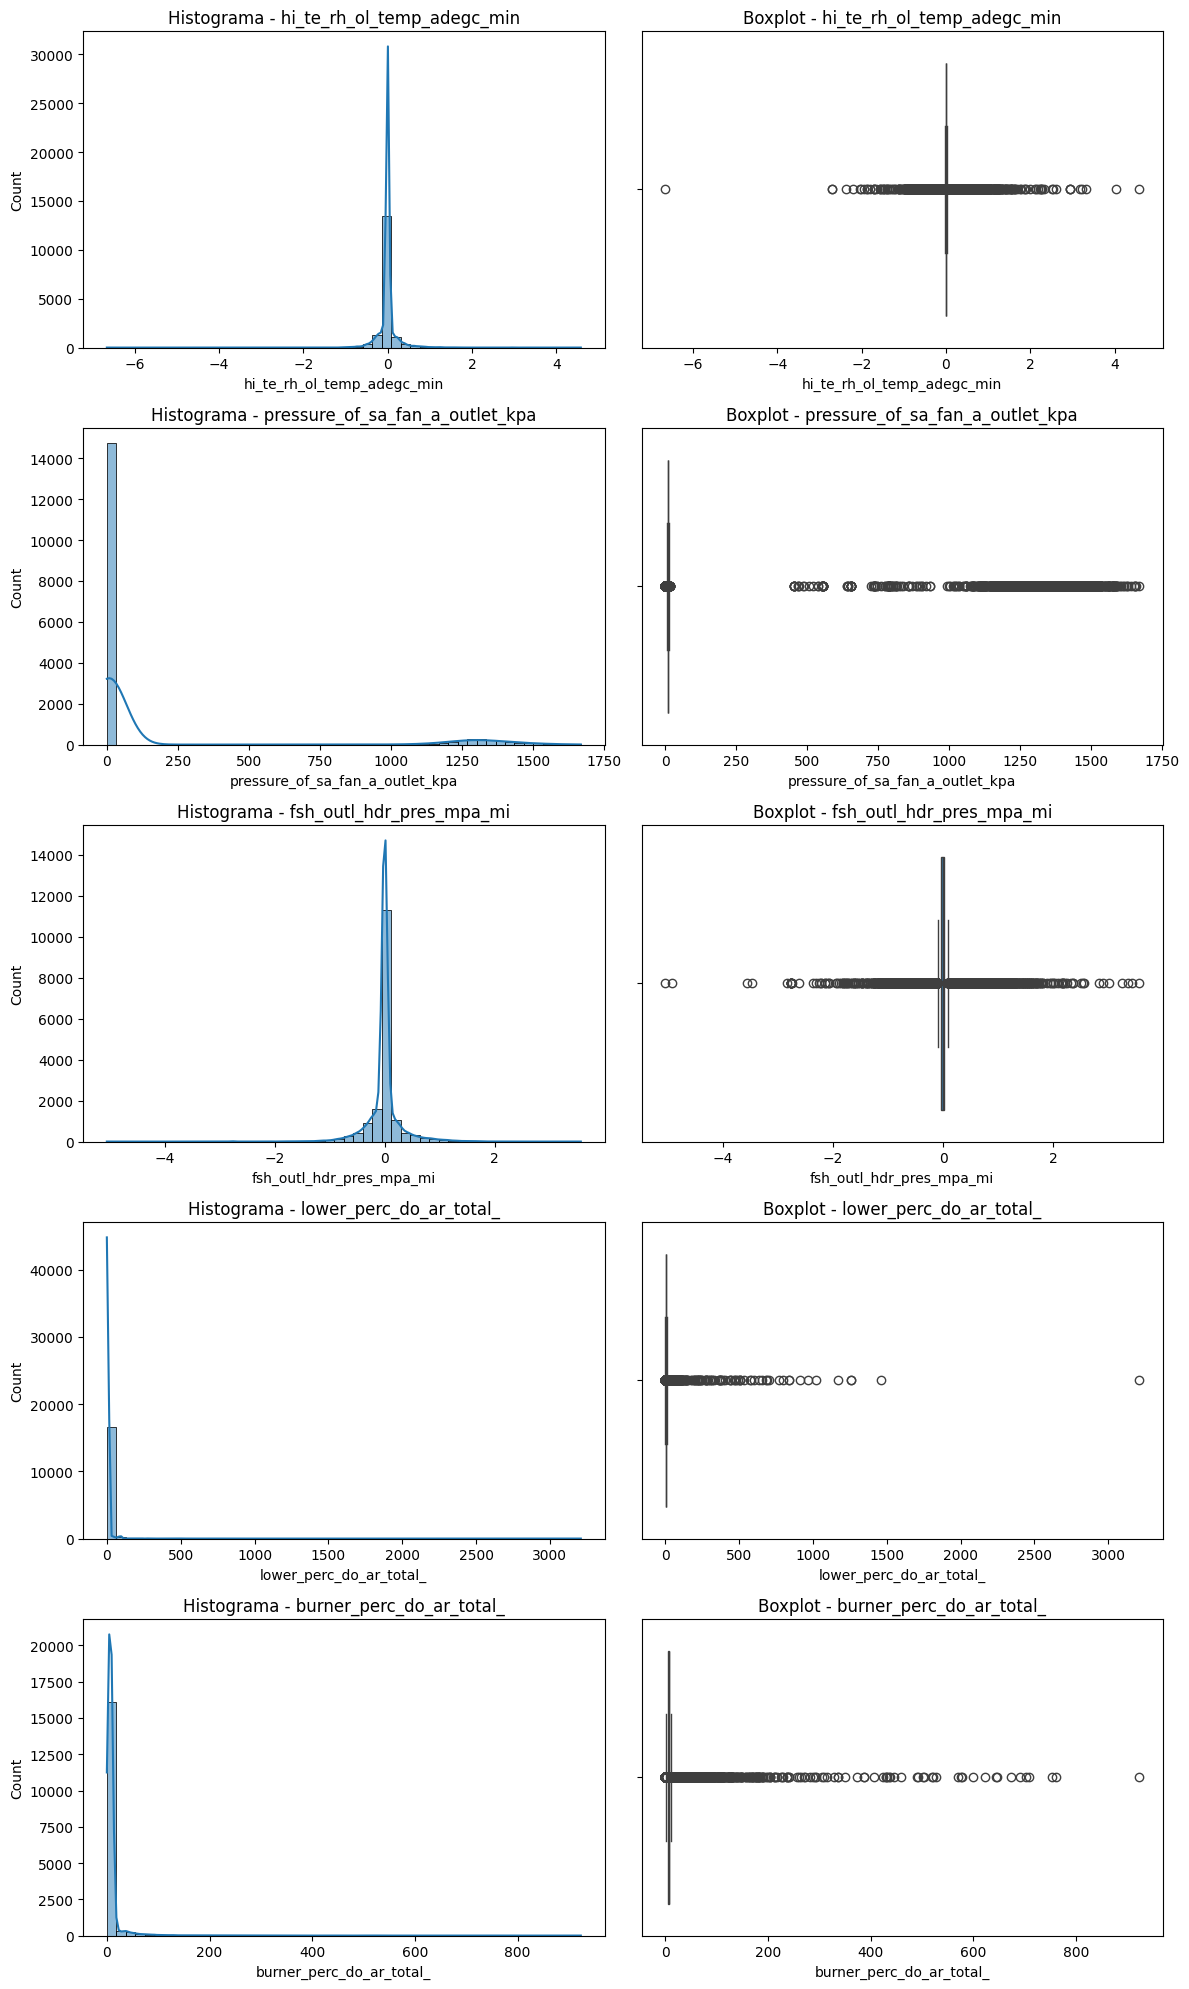

In [53]:
# 📊 ETAPA A1: DISTRIBUIÇÃO E BOXPLOT DAS TOP 5 VARIÁVEIS COM MAIS OUTLIERS

import matplotlib.pyplot as plt
import seaborn as sns

# Selecionar top 5 colunas críticas
top5_cols = outliers_df.head(5)["coluna"].tolist()

# Criar subplots
fig, axes = plt.subplots(len(top5_cols), 2, figsize=(12, 4 * len(top5_cols)))

for i, col in enumerate(top5_cols):
    # Histograma
    sns.histplot(df[col].dropna(), bins=50, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Histograma - {col}")
    
    # Boxplot
    sns.boxplot(x=df[col], ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot - {col}")

plt.tight_layout()
plt.show()


Vamos criar três novas colunas no dados_para_cura_tratado logo após Timestamp, com as somas:

flw_total_a_t_h → soma de flw_output_of_belt_coal_fdr_a1_t_h e flw_output_of_belt_coal_fdr_a2_t_h

flw_total_b_t_h → soma de flw_output_of_belt_coal_fdr_b1_t_h até flw_output_of_belt_coal_fdr_b4_t_h

flw_total_c_t_h → soma de flw_output_of_belt_coal_fdr_c1_t_h e flw_output_of_belt_coal_fdr_c2_t_h

E depois salvaremos em novo arquivo CSV para preservar a versão original.

In [54]:
# 🔧 ETAPA A1: CRIAR TOTAIS DE FLUXO DE CARVÃO POR GRUPO

# Garantir que as colunas existem
cols_a = ["flw_output_of_belt_coal_fdr_a1_t_h", "flw_output_of_belt_coal_fdr_a2_t_h"]
cols_b = ["flw_output_of_belt_coal_fdr_b1_t_h", "flw_output_of_belt_coal_fdr_b2_t_h",
          "flw_output_of_belt_coal_fdr_b3_t_h", "flw_output_of_belt_coal_fdr_b4_t_h"]
cols_c = ["flw_output_of_belt_coal_fdr_c1_t_h", "flw_output_of_belt_coal_fdr_c2_t_h"]

for group_cols in [cols_a, cols_b, cols_c]:
    for col in group_cols:
        assert col in df.columns, f"Coluna ausente: {col}"

# Criar novas colunas
df.insert(1, "flw_total_a_t_h", df[cols_a].sum(axis=1, skipna=True))
df.insert(2, "flw_total_b_t_h", df[cols_b].sum(axis=1, skipna=True))
df.insert(3, "flw_total_c_t_h", df[cols_c].sum(axis=1, skipna=True))

# Salvar em novo arquivo
from pathlib import Path
CAMINHO_SAIDA_TOTAL = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_tratado_com_totais.csv")
df.to_csv(CAMINHO_SAIDA_TOTAL, sep=";", encoding="utf-8", index=False)

print(f"Arquivo salvo com sucesso em: {CAMINHO_SAIDA_TOTAL}")
print("Shape final:", df.shape)
print("Novas colunas criadas:", ["flw_total_a_t_h", "flw_total_b_t_h", "flw_total_c_t_h"])


Arquivo salvo com sucesso em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_tratado_com_totais.csv
Shape final: (17448, 149)
Novas colunas criadas: ['flw_total_a_t_h', 'flw_total_b_t_h', 'flw_total_c_t_h']


ETAPA A1 — Detectar períodos com fluxo zerado (A, B e C) e sumarizar janelas ±10h
Nesta etapa vamos:

Ler o arquivo tratado com totais (dados_para_cura_tratado_com_totais.csv);

Detectar todos os períodos consecutivos em que flw_total_a_t_h, flw_total_b_t_h ou flw_total_c_t_h ficaram iguais a zero;

Produzir uma tabela-resumo com início, fim, duração e as janelas sugeridas de visualização (10 horas antes do primeiro zero e 10 horas após o último zero).

Não vamos imprimir as linhas das janelas ainda; primeiro listaremos os períodos encontrados para você escolher quais quer ver em tela.

In [55]:
# 🔍 ETAPA A1: DETECTAR PERÍODOS ZERADOS E SUGERIR JANELAS ±10H

import pandas as pd
from pathlib import Path

CAMINHO = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_tratado_com_totais.csv")
assert CAMINHO.exists(), f"Arquivo não encontrado: {CAMINHO}"

# 1) Leitura e preparo
df = pd.read_csv(CAMINHO, sep=";", encoding="utf-8", low_memory=False)
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="raise", format="%Y-%m-%d %H:%M:%S")
df = df.sort_values("Timestamp").reset_index(drop=True)

# 2) Flags de zero (tolerância numérica pequena para floats)
eps = 1e-9
for g in ["a", "b", "c"]:
    col = f"flw_total_{g}_t_h"
    assert col in df.columns, f"Coluna ausente: {col}"
    df[f"is_zero_{g}"] = (df[col].fillna(float("inf")).abs() <= eps)

# 3) Função para encontrar "runs" consecutivos de True
def encontrar_periodos_zeros(flag_series: pd.Series):
    # marca um novo bloco quando muda o valor True/False
    grupos = (flag_series != flag_series.shift(1)).cumsum()
    # filtra somente os grupos onde flag=True
    blocos_true = flag_series[flag_series].groupby(grupos[flag_series])
    if blocos_true.size().empty:
        return pd.DataFrame(columns=["start", "end", "n_linhas"])
    idx_inicio = blocos_true.apply(lambda s: s.index[0])
    idx_fim    = blocos_true.apply(lambda s: s.index[-1])
    n_linhas   = blocos_true.size()
    return pd.DataFrame({"start_idx": idx_inicio, "end_idx": idx_fim, "n_linhas": n_linhas}) \
             .assign(start=lambda d: df.loc[d["start_idx"], "Timestamp"].values,
                     end  =lambda d: df.loc[d["end_idx"],   "Timestamp"].values) \
             .drop(columns=["start_idx","end_idx"])

# 4) Apurar períodos para cada grupo e montar tabela-resumo com janelas ±10h
resumos = []
for g in ["a", "b", "c"]:
    periodos = encontrar_periodos_zeros(df[f"is_zero_{g}"])
    if not periodos.empty:
        periodos = periodos.assign(
            grupo=g.upper(),
            duracao_h=lambda d: (pd.to_datetime(d["end"]) - pd.to_datetime(d["start"])) / pd.Timedelta(hours=1),
            janela_ini=lambda d: pd.to_datetime(d["start"]) - pd.Timedelta(hours=10),
            janela_fim=lambda d: pd.to_datetime(d["end"]) + pd.Timedelta(hours=10),
        )
        resumos.append(periodos[["grupo","start","end","duracao_h","n_linhas","janela_ini","janela_fim"]])

# 5) Concatenar e ordenar
if resumos:
    periodos_zeros = pd.concat(resumos, ignore_index=True).sort_values(["grupo","start"]).reset_index(drop=True)
else:
    periodos_zeros = pd.DataFrame(columns=["grupo","start","end","duracao_h","n_linhas","janela_ini","janela_fim"])

print("Períodos encontrados por grupo (A/B/C) com zero absoluto:")
periodos_zeros.head(20)
print(f"\nTotal de períodos detectados: {len(periodos_zeros)}")


Períodos encontrados por grupo (A/B/C) com zero absoluto:

Total de períodos detectados: 32


In [56]:
# 💾 ETAPA A1: SALVAR TABELA DE PERÍODOS ZERADOS

from pathlib import Path

CAMINHO_SAIDA_PERIODOS = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\periodos_fluxo_zero.csv")

# Salvar apenas se houver períodos detectados
if not periodos_zeros.empty:
    periodos_zeros.to_csv(CAMINHO_SAIDA_PERIODOS, sep=";", encoding="utf-8", index=False)
    print(f"Tabela de períodos com fluxo zero salva em: {CAMINHO_SAIDA_PERIODOS}")
    print(f"Total de períodos registrados: {len(periodos_zeros)}")
else:
    print("Nenhum período com fluxo zero foi detectado. Nenhum arquivo gerado.")


Tabela de períodos com fluxo zero salva em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\periodos_fluxo_zero.csv
Total de períodos registrados: 32


ETAPA A1 — Sumário por grupo (A/B/C): total de horas zeradas, quantidade de períodos e maior período
Nesta etapa:

Carregaremos periodos_fluxo_zero.csv (ou usaremos periodos_zeros já em memória, se existir);

Calcularemos, por grupo: número de períodos, soma de horas zeradas, duração média e maior período;

Salvaremos em periodos_fluxo_zero_por_grupo.csv e exibiremos em tela.

In [57]:
# 🔎 ETAPA A1: SUMÁRIO DE FLUXO ZERO POR GRUPO

import pandas as pd
from pathlib import Path

# 1) Carregar tabela de períodos (do passo anterior)
if 'periodos_zeros' not in globals():
    CAMINHO_PERIODOS = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\periodos_fluxo_zero.csv")
    assert CAMINHO_PERIODOS.exists(), f"Arquivo não encontrado: {CAMINHO_PERIODOS}"
    periodos_zeros = pd.read_csv(CAMINHO_PERIODOS, sep=";", encoding="utf-8", parse_dates=["start","end","janela_ini","janela_fim"])

# 2) Garantias mínimas
cols_req = {"grupo","start","end","duracao_h","n_linhas","janela_ini","janela_fim"}
faltantes = cols_req - set(periodos_zeros.columns)
assert not faltantes, f"Colunas faltando na tabela de períodos: {faltantes}"

# 3) Agregar por grupo, mantendo sobreposições (sem unificar períodos entre A/B/C)
resumo_grupo = (periodos_zeros
    .groupby("grupo", as_index=False)
    .agg(qtd_periodos=("duracao_h","size"),
         horas_zeradas=("duracao_h","sum"),
         duracao_media_h=("duracao_h","mean"),
         maior_periodo_h=("duracao_h","max"))
    .sort_values("grupo")
)

# 4) Salvar e exibir
SAIDA_GRUPOS = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\periodos_fluxo_zero_por_grupo.csv")
resumo_grupo.to_csv(SAIDA_GRUPOS, sep=";", encoding="utf-8", index=False)

print("Resumo por grupo salvo em:", SAIDA_GRUPOS)
resumo_grupo


Resumo por grupo salvo em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\periodos_fluxo_zero_por_grupo.csv


grupo  qtd_periodos  horas_zeradas  duracao_media_h  maior_periodo_h
0     A            13         2744.0       211.076923           1239.0
1     B             6         2030.0       338.333333           1225.0
2     C            13         2593.0       199.461538            690.0

📄 ETAPA A1 — Gerar tabela de paradas por sistema (A, B, C)
Nesta etapa:

Carregaremos o dados_para_cura_tratado_com_totais.csv;

Detectaremos períodos consecutivos de zero por cada sistema;

Salvaremos no arquivo periodos_paradas_por_sistema.csv com início, fim e duração.

In [58]:
# 🔍 ETAPA A1: PARADAS POR SISTEMA (A, B, C)

import pandas as pd
from pathlib import Path

# 1) Caminho do dataset tratado
CAMINHO_DADOS = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_tratado_com_totais.csv")

# 2) Leitura e ordenação
df = pd.read_csv(CAMINHO_DADOS, sep=";", encoding="utf-8", parse_dates=["Timestamp"])
df = df.sort_values("Timestamp").reset_index(drop=True)

# 3) Função para encontrar períodos de zeros consecutivos
def encontrar_paradas(col_fluxo, grupo_nome):
    flag_zero = df[col_fluxo].fillna(float("inf")).abs() < 1e-9
    grupos = (flag_zero != flag_zero.shift()).cumsum()
    blocos_true = flag_zero[flag_zero].groupby(grupos[flag_zero])
    registros = []
    for _, idxs in blocos_true.groups.items():
        inicio = df.loc[idxs[0], "Timestamp"]
        fim = df.loc[idxs[-1], "Timestamp"]
        duracao_h = (fim - inicio) / pd.Timedelta(hours=1)
        registros.append([grupo_nome, inicio, fim, round(duracao_h, 3)])
    return registros

# 4) Rodar para A, B e C
paradas = []
paradas += encontrar_paradas("flw_total_a_t_h", "A")
paradas += encontrar_paradas("flw_total_b_t_h", "B")
paradas += encontrar_paradas("flw_total_c_t_h", "C")

# 5) Criar DataFrame
df_paradas = pd.DataFrame(paradas, columns=["grupo", "inicio", "fim", "duracao_h"])
df_paradas = df_paradas.sort_values(["grupo", "inicio"]).reset_index(drop=True)

# 6) Salvar CSV
CAMINHO_SAIDA = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\periodos_paradas_por_sistema.csv")
df_paradas.to_csv(CAMINHO_SAIDA, sep=";", encoding="utf-8", index=False)

print(f"Arquivo gerado: {CAMINHO_SAIDA}")
print(f"Total de paradas registradas: {len(df_paradas)}")
df_paradas.head(20)


Arquivo gerado: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\periodos_paradas_por_sistema.csv
Total de paradas registradas: 32


grupo              inicio                 fim  duracao_h
0      A 2023-03-03 23:00:00 2023-03-03 23:00:00        0.0
1      A 2023-04-04 20:00:00 2023-05-26 11:00:00     1239.0
2      A 2023-08-25 23:00:00 2023-08-29 20:00:00       93.0
3      A 2023-09-01 12:00:00 2023-09-13 12:00:00      288.0
4      A 2023-09-13 16:00:00 2023-09-25 02:00:00      274.0
5      A 2024-01-01 23:00:00 2024-01-02 18:00:00       19.0
6      A 2024-01-03 02:00:00 2024-01-05 13:00:00       59.0
7      A 2024-04-01 10:00:00 2024-04-01 15:00:00        5.0
8      A 2024-04-17 04:00:00 2024-04-17 18:00:00       14.0
9      A 2024-08-30 13:00:00 2024-08-31 20:00:00       31.0
10     A 2024-09-01 13:00:00 2024-09-27 21:00:00      632.0
11     A 2024-09-28 16:00:00 2024-09-28 18:00:00        2.0
12     A 2024-12-27 07:00:00 2024-12-30 23:00:00       88.0
13     B 2023-03-03 23:00:00 2023-03-03 23:00:00        0.0
14     B 2023-04-05 10:00:00 2023-05-26 11:00:00     1225.0
15     B 2024-04-20 12:00:00 2024-04-24 17:00:00      101.0
16     B 2024-08-30 13:00:00 2024-08-31 20:00:00       31.0
17     B 2024-09-01 13:00:00 2024-09-27 21:00:00      632.0
18     B 2024-12-29 06:00:00 2024-12-30 23:00:00       41.0
19     C 2023-03-03 23:00:00 2023-03-03 23:00:00        0.0

ETAPA A1 — Visualização das paradas por sistema (linha do tempo)
Nesta etapa:

Carregaremos periodos_paradas_por_sistema.csv (grupo, inicio, fim, duracao_h).

Faremos um gráfico único tipo Gantt com barras horizontais por sistema A, B e C.

Sobreposições entre sistemas ficam visíveis por estarem em faixas diferentes no eixo Y.

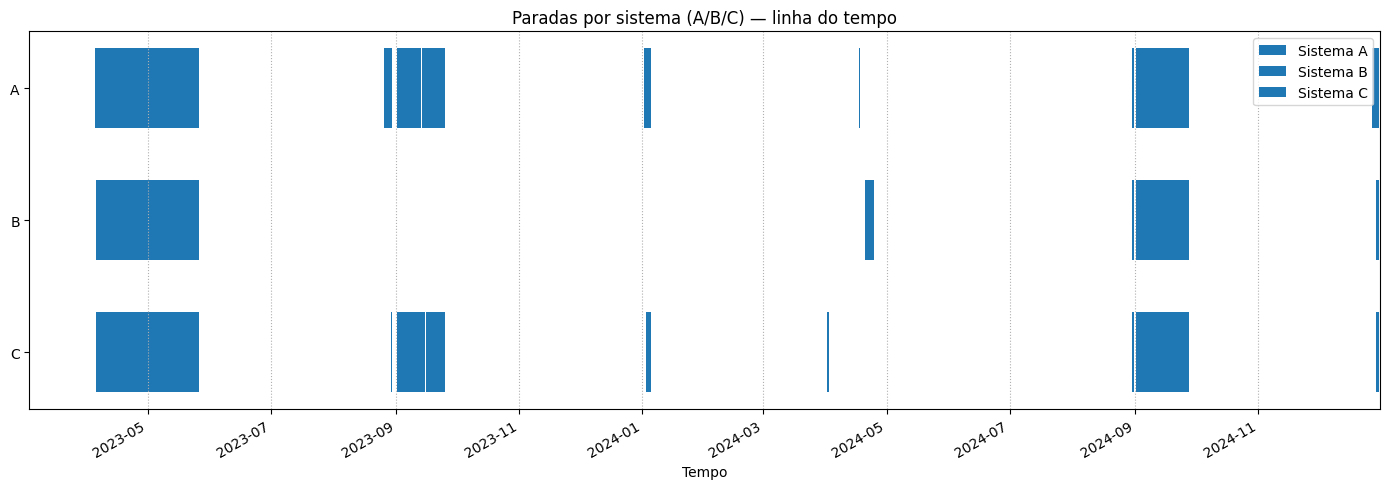

In [59]:
# 🔎 ETAPA A1: LINHA DO TEMPO DE PARADAS POR SISTEMA (GANTT SIMPLES)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

# 1) Carregar períodos
ARQ = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\periodos_paradas_por_sistema.csv")
assert ARQ.exists(), f"Arquivo não encontrado: {ARQ}"
paradas = pd.read_csv(ARQ, sep=";", encoding="utf-8", parse_dates=["inicio", "fim"])
paradas = paradas.sort_values(["grupo", "inicio"]).reset_index(drop=True)

# 2) Converter para numérico do matplotlib
paradas["inicio_num"] = mdates.date2num(paradas["inicio"])
paradas["fim_num"] = mdates.date2num(paradas["fim"])
paradas["dur_num"] = paradas["fim_num"] - paradas["inicio_num"]

# 3) Preparar faixas por grupo
faixas = {"A": (30, 6), "B": (20, 6), "C": (10, 6)}  # (y, altura)

fig, ax = plt.subplots(figsize=(14, 5))

# 4) Plotar barras por grupo
for g, (y, h) in faixas.items():
    dados_g = paradas[paradas["grupo"] == g]
    if dados_g.empty:
        continue
    # broken_barh recebe uma lista de tuplas (x_inicio, largura)
    barras = list(zip(dados_g["inicio_num"], dados_g["dur_num"]))
    ax.broken_barh(barras, (y, h), label=f"Sistema {g}")

# 5) Formatação do eixo X como datas
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(ax.xaxis.get_major_locator()))
fig.autofmt_xdate()

# 6) Rótulos e grade
ax.set_xlabel("Tempo")
ax.set_yticks([faixas["A"][0] + faixas["A"][1]/2,
               faixas["B"][0] + faixas["B"][1]/2,
               faixas["C"][0] + faixas["C"][1]/2])
ax.set_yticklabels(["A", "B", "C"])
ax.set_title("Paradas por sistema (A/B/C) — linha do tempo")
ax.grid(True, axis="x", linestyle=":")

# 7) Legenda e limites
ax.legend(loc="upper right")
# Ajuste opcional de margens horizontais
xmin = paradas["inicio_num"].min() - 0.5
xmax = paradas["fim_num"].max() + 0.5
ax.set_xlim(xmin, xmax)

plt.tight_layout()
plt.show()


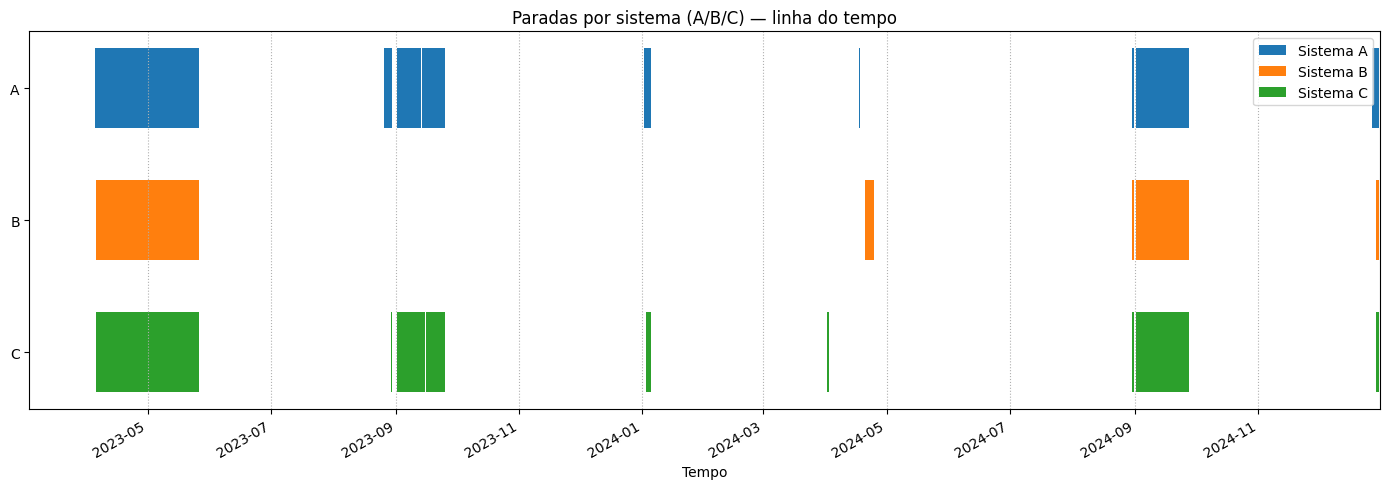

In [60]:
# 🔎 ETAPA A1: LINHA DO TEMPO DE PARADAS POR SISTEMA (CORES DISTINTAS)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

# 1) Carregar períodos
ARQ = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\periodos_paradas_por_sistema.csv")
paradas = pd.read_csv(ARQ, sep=";", encoding="utf-8", parse_dates=["inicio", "fim"])
paradas = paradas.sort_values(["grupo", "inicio"]).reset_index(drop=True)

# 2) Converter datas para formato numérico do matplotlib
paradas["inicio_num"] = mdates.date2num(paradas["inicio"])
paradas["fim_num"] = mdates.date2num(paradas["fim"])
paradas["dur_num"] = paradas["fim_num"] - paradas["inicio_num"]

# 3) Definir faixas no eixo Y e cores
faixas = {"A": (30, 6), "B": (20, 6), "C": (10, 6)}
cores = {"A": "tab:blue", "B": "tab:orange", "C": "tab:green"}

fig, ax = plt.subplots(figsize=(14, 5))

# 4) Plotar cada grupo com sua cor
for g, (y, h) in faixas.items():
    dados_g = paradas[paradas["grupo"] == g]
    if dados_g.empty:
        continue
    barras = list(zip(dados_g["inicio_num"], dados_g["dur_num"]))
    ax.broken_barh(barras, (y, h), facecolors=cores[g], label=f"Sistema {g}")

# 5) Eixo X como datas
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(ax.xaxis.get_major_locator()))
fig.autofmt_xdate()

# 6) Rótulos, legenda e grade
ax.set_xlabel("Tempo")
ax.set_yticks([faixas["A"][0] + faixas["A"][1]/2,
               faixas["B"][0] + faixas["B"][1]/2,
               faixas["C"][0] + faixas["C"][1]/2])
ax.set_yticklabels(["A", "B", "C"])
ax.set_title("Paradas por sistema (A/B/C) — linha do tempo")
ax.grid(True, axis="x", linestyle=":")

ax.legend(loc="upper right")
ax.set_xlim(paradas["inicio_num"].min() - 0.5, paradas["fim_num"].max() + 0.5)

plt.tight_layout()
plt.show()


ETAPA A1 — Rotular EM OPERAÇÃO vs FORA DE OPERAÇÃO e salvar em dois arquivos
Nesta etapa:

Carregamos dados_para_cura_tratado_com_totais.csv;

Detectamos os períodos de zero em flw_total_c_t_h;

Construímos janelas [início_zero, fim_zero + 48h] e unimos sobreposições;

Rotulamos cada linha como “FORA DE OPERAÇÃO” se o Timestamp cair em qualquer janela; caso contrário, “EM OPERAÇÃO”;

Salvamos dois CSVs resultantes.

In [61]:
# 🔧 ETAPA A1: ROTULAR E SALVAR "EM OPERAÇÃO" E "FORA DE OPERAÇÃO" BASEADO NO SISTEMA C

import pandas as pd
from pathlib import Path

# 1) Caminhos
ARQ_IN = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_tratado_com_totais.csv")
ARQ_OUT_ON  = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_operacao.csv")
ARQ_OUT_OFF = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_fora_de_operacao.csv")

assert ARQ_IN.exists(), f"Arquivo de entrada não encontrado: {ARQ_IN}"

# 2) Leitura e preparo
df = pd.read_csv(ARQ_IN, sep=";", encoding="utf-8", low_memory=False, parse_dates=["Timestamp"])
df = df.sort_values("Timestamp").reset_index(drop=True)
assert "flw_total_c_t_h" in df.columns, "Coluna 'flw_total_c_t_h' não encontrada."

# 3) Identificar períodos consecutivos com C == 0
eps = 1e-9
flag_zero_c = (df["flw_total_c_t_h"].fillna(float("inf")).abs() <= eps)

# Delimitação de blocos True consecutivos
grupo_ids = (flag_zero_c != flag_zero_c.shift()).cumsum()
blocos_true = flag_zero_c[flag_zero_c].groupby(grupo_ids[flag_zero_c])

periodos = []
for _, idxs in blocos_true.groups.items():
    ini = df.loc[idxs[0], "Timestamp"]
    fim = df.loc[idxs[-1], "Timestamp"]
    # Janela de "fora de operação": do início do zero até 48h após o fim
    periodos.append([ini, fim + pd.Timedelta(hours=48)])

# 4) Unir janelas que se sobrepõem ou são contíguas
periodos.sort(key=lambda x: x[0])
janelas_unidas = []
for ini, fim in periodos:
    if not janelas_unidas:
        janelas_unidas.append([ini, fim])
    else:
        last_ini, last_fim = janelas_unidas[-1]
        if ini <= last_fim:  # sobreposição/contiguidade
            janelas_unidas[-1][1] = max(last_fim, fim)
        else:
            janelas_unidas.append([ini, fim])

# 5) Rotular linhas: FORA DE OPERAÇÃO se cair em qualquer janela unida
fora_mask = pd.Series(False, index=df.index)
for ini, fim in janelas_unidas:
    fora_mask |= (df["Timestamp"] >= ini) & (df["Timestamp"] <= fim)

df["status_operacao"] = pd.Series("EM OPERAÇÃO", index=df.index)
df.loc[fora_mask, "status_operacao"] = "FORA DE OPERAÇÃO"

# 6) Particionar e salvar
df_operacao = df[df["status_operacao"] == "EM OPERAÇÃO"].copy()
df_fora     = df[df["status_operacao"] == "FORA DE OPERAÇÃO"].copy()

df_operacao.to_csv(ARQ_OUT_ON, sep=";", encoding="utf-8", index=False)
df_fora.to_csv(ARQ_OUT_OFF, sep=";", encoding="utf-8", index=False)

print("Arquivos gerados com sucesso.")
print(f"- EM OPERAÇÃO:      {ARQ_OUT_ON}  | linhas: {len(df_operacao)}")
print(f"- FORA DE OPERAÇÃO: {ARQ_OUT_OFF} | linhas: {len(df_fora)}")
print(f"Total original: {len(df)}")
print("\nResumo das janelas unidas (primeiras 10):")
for i, (ini, fim) in enumerate(janelas_unidas[:10], start=1):
    print(f"{i:02d}) {ini}  ->  {fim}  (dur: {(fim - ini) / pd.Timedelta(hours=1):.2f} h)")


Arquivos gerados com sucesso.
- EM OPERAÇÃO:      C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_operacao.csv  | linhas: 14419
- FORA DE OPERAÇÃO: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_fora_de_operacao.csv | linhas: 3029
Total original: 17448

Resumo das janelas unidas (primeiras 10):
01) 2023-03-03 23:00:00  ->  2023-03-05 23:00:00  (dur: 48.00 h)
02) 2023-04-05 10:00:00  ->  2023-05-28 11:00:00  (dur: 1273.00 h)
03) 2023-08-28 13:00:00  ->  2023-08-31 20:00:00  (dur: 79.00 h)
04) 2023-09-01 12:00:00  ->  2023-09-27 02:00:00  (dur: 614.00 h)
05) 2024-01-02 23:00:00  ->  2024-01-07 13:00:00  (dur: 110.00 h)
06) 2024-04-01 18:00:00  ->  2024-04-04 15:00:00  (dur: 69.00 h)
07) 2024-04-29 02:00:00  ->  2024-05-01 12:00:00  (dur: 58.00 h)
08) 2024-08-30 13:00:00  ->  2024-09-29 21:00:00  (dur: 728.00 h)
09) 2024-12-29 06:00:00  ->  2025-01-01 23:00:00  (dur: 89.00 h)


Esse código:

Lê apenas os dados “EM OPERAÇÃO”;

Seleciona todas as colunas numéricas para análise;

Gera um histograma + boxplot lado a lado para cada variável;

Mantém a mesma abordagem visual anterior, mas sem dados de “fora de operação”, permitindo ver apenas os outliers reais de operação.

In [62]:
# 🔧 ETAPA A2: ANÁLISE DE OUTLIERS APENAS PARA "EM OPERAÇÃO"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 1) Caminho do arquivo filtrado
ARQ_IN_OPERACAO = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_operacao.csv")
assert ARQ_IN_OPERACAO.exists(), f"Arquivo não encontrado: {ARQ_IN_OPERACAO}"

# 2) Leitura
df_op = pd.read_csv(ARQ_IN_OPERACAO, sep=";", encoding="utf-8", low_memory=False, parse_dates=["Timestamp"])

# 3) Selecionar apenas colunas numéricas (exceto Timestamp)
numeric_cols = df_op.select_dtypes(include=["number"]).columns

# 4) Plotar histograma e boxplot para cada coluna numérica
num_vars = len(numeric_cols)
cols_plot = 2
rows_plot = num_vars

plt.figure(figsize=(12, 4 * rows_plot))

for i, col in enumerate(numeric_cols, start=1):
    # Histograma
    plt.subplot(rows_plot, cols_plot, (i - 1) * cols_plot + 1)
    sns.histplot(df_op[col].dropna(), kde=True, bins=50)
    plt.title(f"Histograma - {col}")
    
    # Boxplot
    plt.subplot(rows_plot, cols_plot, (i - 1) * cols_plot + 2)
    sns.boxplot(x=df_op[col].dropna())
    plt.title(f"Boxplot - {col}")

plt.tight_layout()
plt.show()


ETAPA A2 — Recalcular os totais A/B/C com min_count=1 e salvar nova versão
Nesta etapa vamos:

Reabrir o dataset tratado sem os totais consolidados.

Recriar flw_total_a_t_h, flw_total_b_t_h, flw_total_c_t_h com min_count=1.

Salvar como uma nova versão com sufixo _v2 para manter rastreabilidade.

Verificar rapidamente a incidência de zeros e NaNs nos novos totais.

In [63]:
# 🔧 ETAPA A2: RECRIAR TOTAIS A/B/C COM min_count=1 (SEM ZEROS ARTIFICIAIS)

import pandas as pd
from pathlib import Path

ARQ_BASE = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_tratado.csv")
ARQ_OUT  = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_tratado_com_totais_v2.csv")

df = pd.read_csv(ARQ_BASE, sep=";", encoding="utf-8", low_memory=False, parse_dates=["Timestamp"])
df = df.sort_values("Timestamp").reset_index(drop=True)

cols_a = ["flw_output_of_belt_coal_fdr_a1_t_h", "flw_output_of_belt_coal_fdr_a2_t_h"]
cols_b = ["flw_output_of_belt_coal_fdr_b1_t_h", "flw_output_of_belt_coal_fdr_b2_t_h",
          "flw_output_of_belt_coal_fdr_b3_t_h", "flw_output_of_belt_coal_fdr_b4_t_h"]
cols_c = ["flw_output_of_belt_coal_fdr_c1_t_h", "flw_output_of_belt_coal_fdr_c2_t_h"]

# Garantias
for c in cols_a + cols_b + cols_c:
    assert c in df.columns, f"Coluna ausente: {c}"

# Recriar totais: se todas forem NaN, resultado = NaN (não 0)
df["flw_total_a_t_h"] = df[cols_a].sum(axis=1, min_count=1)
df["flw_total_b_t_h"] = df[cols_b].sum(axis=1, min_count=1)
df["flw_total_c_t_h"] = df[cols_c].sum(axis=1, min_count=1)

# Persistir nova versão
df.to_csv(ARQ_OUT, sep=";", encoding="utf-8", index=False)

# Checagens rápidas
def resumo(col):
    return {
        "zeros": int((df[col] == 0).sum()),
        "nulos": int(df[col].isna().sum()),
        "min": float(df[col].min(skipna=True)),
        "max": float(df[col].max(skipna=True))
    }

print("Arquivo salvo:", ARQ_OUT)
print("Resumo dos totais (zeros agora devem ser bem mais raros e somente reais):")
print("A:", resumo("flw_total_a_t_h"))
print("B:", resumo("flw_total_b_t_h"))
print("C:", resumo("flw_total_c_t_h"))


Arquivo salvo: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_tratado_com_totais_v2.csv
Resumo dos totais (zeros agora devem ser bem mais raros e somente reais):
A: {'zeros': 0, 'nulos': 2757, 'min': 0.13, 'max': 119.588}
B: {'zeros': 0, 'nulos': 2036, 'min': -0.6619999999999999, 'max': 195.27700000000002}
C: {'zeros': 0, 'nulos': 2606, 'min': 0.079, 'max': 111.04599999999999}


ETAPA A2 — Recriar totais (min_count=1) e reclassificar “EM OPERAÇÃO” vs “FORA” exigindo C > 0
Nesta etapa:

Recriamos flw_total_[a|b|c]_t_h com min_count=1 (evita zeros por todas-NaN).

“FORA DE OPERAÇÃO”: do início do zero em C até 48h após o fim.

“EM OPERAÇÃO”: fora dessas janelas e com flw_total_c_t_h notna & > 0.

Salvamos novos arquivos *_v2.csv e validamos as condições.

In [64]:
# 🔧 ETAPA A2: RECLASSIFICAÇÃO COM C > 0 E SEM NaN

import pandas as pd
from pathlib import Path

# Arquivos
ARQ_BASE = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_tratado.csv")
ARQ_OP_V2  = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_operacao_v2.csv")
ARQ_OFF_V2 = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_fora_de_operacao_v2.csv")

# 1) Leitura base e ordenação
df = pd.read_csv(ARQ_BASE, sep=";", encoding="utf-8", low_memory=False, parse_dates=["Timestamp"])
df = df.sort_values("Timestamp").reset_index(drop=True)

# 2) Recriar totais com min_count=1 (evita zero artificial em todas-NaN)
cols_a = ["flw_output_of_belt_coal_fdr_a1_t_h","flw_output_of_belt_coal_fdr_a2_t_h"]
cols_b = ["flw_output_of_belt_coal_fdr_b1_t_h","flw_output_of_belt_coal_fdr_b2_t_h",
          "flw_output_of_belt_coal_fdr_b3_t_h","flw_output_of_belt_coal_fdr_b4_t_h"]
cols_c = ["flw_output_of_belt_coal_fdr_c1_t_h","flw_output_of_belt_coal_fdr_c2_t_h"]
for c in cols_a+cols_b+cols_c: assert c in df.columns, f"Faltou: {c}"

df["flw_total_a_t_h"] = df[cols_a].sum(axis=1, min_count=1)
df["flw_total_b_t_h"] = df[cols_b].sum(axis=1, min_count=1)
df["flw_total_c_t_h"] = df[cols_c].sum(axis=1, min_count=1)

# 3) Construir janelas FORA (zero em C estendido +48h)
eps = 1e-9
flag_zero_c = (df["flw_total_c_t_h"].fillna(float("inf")).abs() <= eps)
grp = (flag_zero_c != flag_zero_c.shift()).cumsum()
periodos = []
for _, idxs in flag_zero_c[flag_zero_c].groupby(grp[flag_zero_c]).groups.items():
    ini = df.loc[idxs[0],"Timestamp"]
    fim = df.loc[idxs[-1],"Timestamp"] + pd.Timedelta(hours=48)
    periodos.append([ini, fim])

# Unir sobreposições
periodos.sort(key=lambda x: x[0])
janelas = []
for ini,fim in periodos:
    if not janelas or ini > janelas[-1][1]:
        janelas.append([ini,fim])
    else:
        janelas[-1][1] = max(janelas[-1][1], fim)

# 4) Máscaras
fora_mask = pd.Series(False, index=df.index)
for ini,fim in janelas:
    fora_mask |= (df["Timestamp"]>=ini) & (df["Timestamp"]<=fim)

oper_mask = (~fora_mask) & df["flw_total_c_t_h"].notna() & (df["flw_total_c_t_h"] > eps)

# 5) Particionar e salvar
df_op   = df[oper_mask].copy()
df_off  = df[~oper_mask].copy()

df_op.to_csv(ARQ_OP_V2, sep=";", encoding="utf-8", index=False)
df_off.to_csv(ARQ_OFF_V2, sep=";", encoding="utf-8", index=False)

# 6) Validações
print("Arquivos v2 gerados.")
print(f"- EM OPERAÇÃO v2: {ARQ_OP_V2} | linhas: {len(df_op)}")
print(f"    C==0: {(df_op['flw_total_c_t_h'].abs()<=eps).sum()}  |  NaN em C: {df_op['flw_total_c_t_h'].isna().sum()}")
print(f"- FORA v2:        {ARQ_OFF_V2} | linhas: {len(df_off)}")
print(f"Total base: {len(df)}")


Arquivos v2 gerados.
- EM OPERAÇÃO v2: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_operacao_v2.csv | linhas: 14842
    C==0: 0  |  NaN em C: 0
- FORA v2:        C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_fora_de_operacao_v2.csv | linhas: 2606
Total base: 17448


In [65]:
# === ANÁLISE DE OUTLIERS APENAS PARA "EM OPERAÇÃO v2" ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Caminho do arquivo corrigido
caminho_operacao_v2 = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_operacao_v2.csv"

# Carregar o dataset
df_operacao_v2 = pd.read_csv(caminho_operacao_v2, sep=",", parse_dates=["Timestamp"])

# Selecionar apenas colunas numéricas para análise
colunas_numericas = df_operacao_v2.select_dtypes(include=["float64", "int64"]).columns

# Criar gráficos para cada coluna
for col in colunas_numericas:
    plt.figure(figsize=(10, 4))
    
    # Histograma
    plt.subplot(1, 2, 1)
    sns.histplot(df_operacao_v2[col].dropna(), kde=True, bins=50)
    plt.title(f"Histograma - {col}")
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_operacao_v2[col].dropna())
    plt.title(f"Boxplot - {col}")
    
    plt.tight_layout()
    plt.show()

# Resumo numérico dos possíveis outliers (usando IQR)
outliers_info = {}
for col in colunas_numericas:
    Q1 = df_operacao_v2[col].quantile(0.25)
    Q3 = df_operacao_v2[col].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    outliers = df_operacao_v2[(df_operacao_v2[col] < lim_inf) | (df_operacao_v2[col] > lim_sup)][col]
    outliers_info[col] = len(outliers)

print("\nQuantidade de outliers por coluna (IQR):")
for coluna, qtd in outliers_info.items():
    print(f"{coluna}: {qtd}")


ValueError: Missing column provided to 'parse_dates': 'Timestamp'

ETAPA A2 — Releitura correta do dados_para_cura_operacao_v2.csv (validação de colunas)
Nesta etapa:

Ler o arquivo com sep=";";

Validar presença de Timestamp e dos totais A/B/C;

Fazer uma checagem rápida de zeros e NaNs nos totais para garantir que o pico no zero não voltará nos gráficos.

In [66]:
# 🔧 ETAPA A2: RELEITURA CORRETA E VALIDAÇÃO BÁSICA

import pandas as pd
from pathlib import Path

caminho_operacao_v2 = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_operacao_v2.csv")
assert caminho_operacao_v2.exists(), f"Arquivo não encontrado: {caminho_operacao_v2}"

# Leitura correta: separador ';'
df_operacao_v2 = pd.read_csv(
    caminho_operacao_v2,
    sep=";",
    encoding="utf-8",
    low_memory=False,
    parse_dates=["Timestamp"]
)

# Checagens mínimas
req_cols = ["Timestamp","flw_total_a_t_h","flw_total_b_t_h","flw_total_c_t_h"]
faltantes = [c for c in req_cols if c not in df_operacao_v2.columns]
assert not faltantes, f"Colunas ausentes: {faltantes}"

print("Shape:", df_operacao_v2.shape)
print("Primeiras colunas:", list(df_operacao_v2.columns[:10]))

# Checagem de zeros/NaNs nos totais (não deve haver zeros artificiais)
for col in ["flw_total_a_t_h","flw_total_b_t_h","flw_total_c_t_h"]:
    zeros = int((df_operacao_v2[col] == 0).sum())
    nulos = int(df_operacao_v2[col].isna().sum())
    print(f"{col} -> zeros: {zeros} | nulos: {nulos} | min: {df_operacao_v2[col].min(skipna=True)} | max: {df_operacao_v2[col].max(skipna=True)}")


Shape: (14842, 149)
Primeiras colunas: ['Timestamp', 'flw_output_of_belt_coal_fdr_a1_t_h', 'flw_output_of_belt_coal_fdr_a2_t_h', 'flw_output_of_belt_coal_fdr_b1_t_h', 'flw_output_of_belt_coal_fdr_b2_t_h', 'flw_output_of_belt_coal_fdr_b3_t_h', 'flw_output_of_belt_coal_fdr_b4_t_h', 'flw_output_of_belt_coal_fdr_c1_t_h', 'flw_output_of_belt_coal_fdr_c2_t_h', 'porcentagem_de_ar_primario_']
flw_total_a_t_h -> zeros: 0 | nulos: 190 | min: 0.13 | max: 119.588
flw_total_b_t_h -> zeros: 0 | nulos: 103 | min: -0.6619999999999999 | max: 195.277
flw_total_c_t_h -> zeros: 0 | nulos: 0 | min: 0.079 | max: 111.046


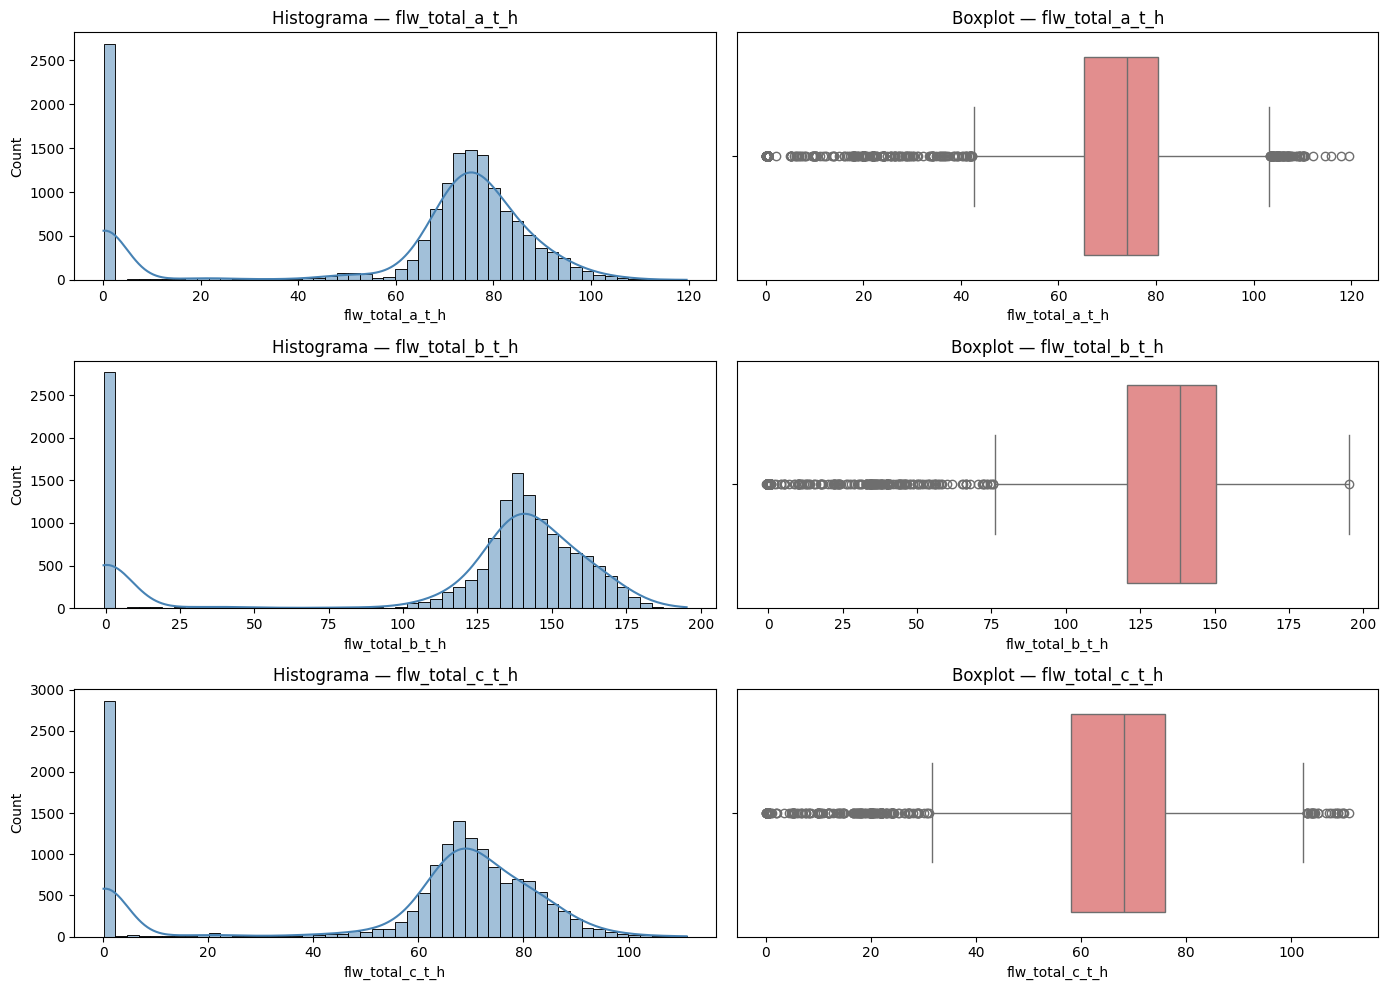


--- Outliers detectados pelo método IQR ---
flw_total_a_t_h: 2963 outliers (19.96%)
flw_total_b_t_h: 2948 outliers (19.86%)
flw_total_c_t_h: 3059 outliers (20.61%)


In [67]:
# 🔧 ETAPA A3: ANÁLISE DE OUTLIERS (IQR) — EM OPERAÇÃO

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

colunas_alvo = ["flw_total_a_t_h","flw_total_b_t_h","flw_total_c_t_h"]

plt.figure(figsize=(14, 10))

for i, col in enumerate(colunas_alvo, start=1):
    # Histogram + KDE
    plt.subplot(len(colunas_alvo), 2, 2*i-1)
    sns.histplot(df_operacao_v2[col], kde=True, bins=50, color="steelblue")
    plt.title(f"Histograma — {col}")
    
    # Boxplot com outliers
    plt.subplot(len(colunas_alvo), 2, 2*i)
    sns.boxplot(x=df_operacao_v2[col], color="lightcoral")
    plt.title(f"Boxplot — {col}")
    
plt.tight_layout()
plt.show()

# Calcular limites e contagens de outliers
print("\n--- Outliers detectados pelo método IQR ---")
for col in colunas_alvo:
    q1 = df_operacao_v2[col].quantile(0.25)
    q3 = df_operacao_v2[col].quantile(0.75)
    iqr = q3 - q1
    lim_inf = q1 - 1.5 * iqr
    lim_sup = q3 + 1.5 * iqr
    outliers = df_operacao_v2[(df_operacao_v2[col] < lim_inf) | (df_operacao_v2[col] > lim_sup)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df_operacao_v2)*100:.2f}%)")


Entendi o problema — esses picos no zero que aparecem nos histogramas indicam que ainda existem valores muito próximos de zero (ou exatamente zero) que não foram removidos na filtragem para “em operação”.
Isso pode acontecer por dois motivos principais:

Zeros disfarçados — valores como 0.0, 0.0001, 1e-10 ou até -0.0 que não foram considerados no filtro.

Gaps na seleção temporal — o critério de “fora de operação” não removeu alguns períodos de zero que estão fora das janelas críticas, mas que deveriam estar.

O que vamos precisar fazer agora é:

Filtrar novamente apenas os dados em operação removendo qualquer registro onde A, B ou C estejam abaixo de um limite mínimo (por exemplo, 0.5 t/h).

Garantir que esse filtro seja aplicado antes da análise de outliers.

Se quiser, já te passo o código para:

Reaplicar esse filtro de forma segura.

Salvar o dataset limpo em dados_para_cura_operacao_v3.csv.

Refazer os histogramas sem a barra de zeros.







Perguntar ao ChatGPT


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Caminho do arquivo "em operação" versão 2
caminho_operacao_v2 = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_operacao_v2.csv"

# Carregar o dataset
df_operacao_v2 = pd.read_csv(caminho_operacao_v2, sep=",", parse_dates=["Timestamp"])

# Definir limite mínimo para considerar como fluxo válido
LIMITE_MIN = 0.5

# Remover linhas onde qualquer sistema tenha fluxo abaixo do limite
df_filtrado = df_operacao_v2[
    (df_operacao_v2["flw_total_a_t_h"] >= LIMITE_MIN) &
    (df_operacao_v2["flw_total_b_t_h"] >= LIMITE_MIN) &
    (df_operacao_v2["flw_total_c_t_h"] >= LIMITE_MIN)
]

# Salvar dataset filtrado
caminho_saida = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_operacao_v3.csv"
df_filtrado.to_csv(caminho_saida, index=False)
print(f"Arquivo salvo: {caminho_saida} | Linhas: {len(df_filtrado)}")

# Plotar histogramas e boxplots para verificar se zeros sumiram
colunas_fluxo = ["flw_total_a_t_h", "flw_total_b_t_h", "flw_total_c_t_h"]

plt.figure(figsize=(14, 10))
for i, col in enumerate(colunas_fluxo):
    plt.subplot(3, 2, 2*i + 1)
    sns.histplot(df_filtrado[col], bins=50, kde=True)
    plt.title(f"Histograma — {col}")

    plt.subplot(3, 2, 2*i + 2)
    sns.boxplot(x=df_filtrado[col], color="lightblue")
    plt.title(f"Boxplot — {col}")

plt.tight_layout()
plt.show()


ValueError: Missing column provided to 'parse_dates': 'Timestamp'

Shape original: (14842, 149)
flw_total_a_t_h: zeros=0 | near0(<0.5)=2680 | nans=190 | min=0.13 | max=119.588
flw_total_b_t_h: zeros=0 | near0(<0.5)=2457 | nans=103 | min=-0.6619999999999999 | max=195.277
flw_total_c_t_h: zeros=0 | near0(<0.5)=2857 | nans=0 | min=0.079 | max=111.046

Arquivo salvo: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_operacao_v3.csv
Shape filtrado (v3): (11961, 149)
flw_total_a_t_h (v3): zeros=0 | near0(<0.5)=0 | nans=0 | min=0.505 | max=119.588
flw_total_b_t_h (v3): zeros=0 | near0(<0.5)=0 | nans=0 | min=0.526 | max=195.277
flw_total_c_t_h (v3): zeros=0 | near0(<0.5)=0 | nans=0 | min=0.515 | max=111.046


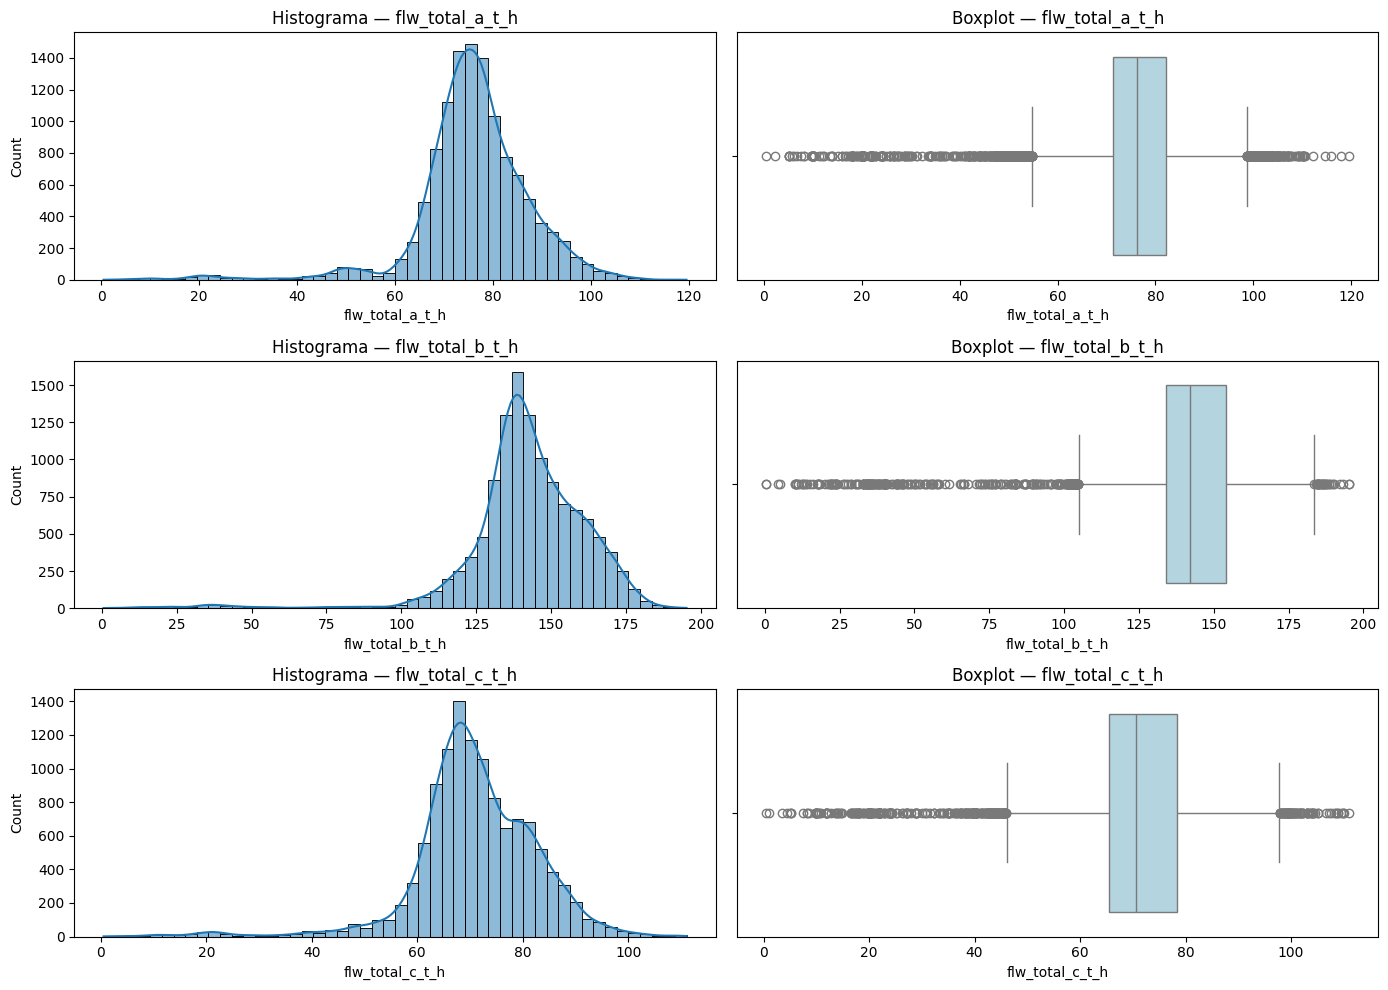

In [69]:
# 🔧 ETAPA A3: LIMPEZA DE RESÍDUOS ~0 EM "EM OPERAÇÃO" E HISTOGRAMAS

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Parâmetros
MIN_FLOW = 0.5
ARQ_IN  = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_operacao_v2.csv")
ARQ_OUT = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_operacao_v3.csv")
COLS = ["flw_total_a_t_h","flw_total_b_t_h","flw_total_c_t_h"]

# 1) Leitura correta (sep=';')
df = pd.read_csv(ARQ_IN, sep=";", encoding="utf-8", low_memory=False, parse_dates=["Timestamp"])

# 2) Diagnóstico pré-filtro
print("Shape original:", df.shape)
for c in COLS:
    zeros = int((df[c] == 0).sum())
    near0 = int((df[c].between(0, MIN_FLOW, inclusive="left")).sum())
    nans  = int(df[c].isna().sum())
    print(f"{c}: zeros={zeros} | near0(<{MIN_FLOW})={near0} | nans={nans} | min={df[c].min(skipna=True)} | max={df[c].max(skipna=True)}")

# 3) Filtro: todos válidos e >= MIN_FLOW
mask_valid = df[COLS].notna().all(axis=1) & (df[COLS] >= MIN_FLOW).all(axis=1)
df_v3 = df.loc[mask_valid].copy()

# 4) Salvar v3
df_v3.to_csv(ARQ_OUT, sep=";", encoding="utf-8", index=False)
print("\nArquivo salvo:", ARQ_OUT)
print("Shape filtrado (v3):", df_v3.shape)

# 5) Checagem pós-filtro
for c in COLS:
    zeros = int((df_v3[c] == 0).sum())
    near0 = int((df_v3[c].between(0, MIN_FLOW, inclusive="left")).sum())
    nans  = int(df_v3[c].isna().sum())
    print(f"{c} (v3): zeros={zeros} | near0(<{MIN_FLOW})={near0} | nans={nans} | min={df_v3[c].min(skipna=True)} | max={df_v3[c].max(skipna=True)}")

# 6) Histogramas e boxplots (A, B, C)
plt.figure(figsize=(14, 10))
for i, col in enumerate(COLS):
    plt.subplot(3, 2, 2*i + 1)
    sns.histplot(df_v3[col], bins=50, kde=True)
    plt.title(f"Histograma — {col}")

    plt.subplot(3, 2, 2*i + 2)
    sns.boxplot(x=df_v3[col], color="lightblue")
    plt.title(f"Boxplot — {col}")

plt.tight_layout()
plt.show()



📄 ETAPA A3 — Linha do tempo dos fluxos (v3) com paradas sombreadas por sistema (A/B/C)
Nesta etapa:

Carrega dados_para_cura_operacao_v3.csv (séries em operação)

Carrega periodos_paradas_por_sistema.csv (início/fim das paradas)

Plota 3 subplots (A, B, C) com a série temporal e faixas sombreadas nas janelas de parada do respectivo sistema

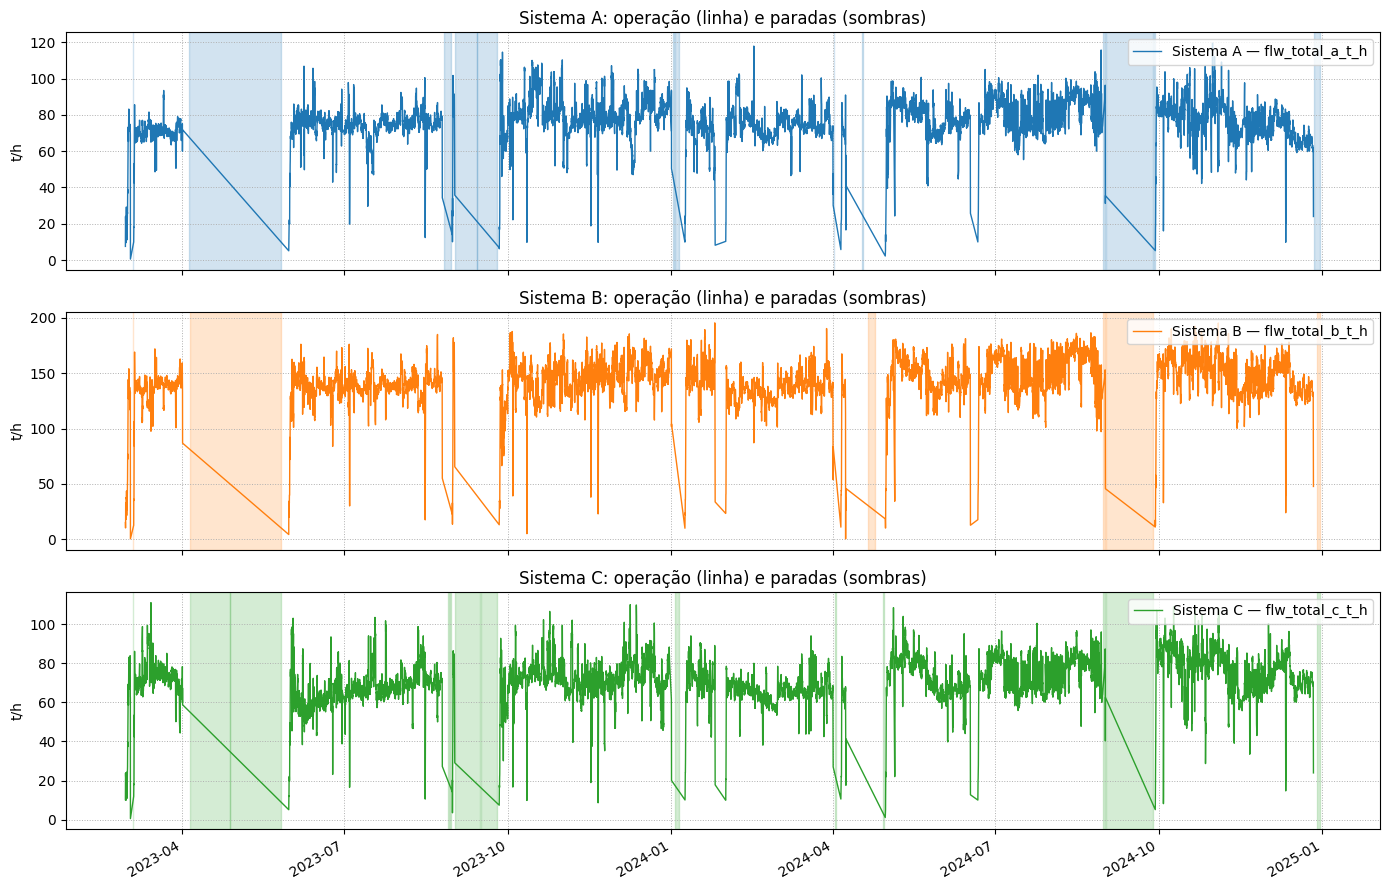

In [70]:
# 🔎 ETAPA A3: SÉRIES (v3) + PARADAS (SOMBREADOS) POR SISTEMA

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

# Arquivos de entrada
ARQ_V3   = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\dados_para_cura_operacao_v3.csv")
ARQ_STOP = Path(r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL\data\staged\periodos_paradas_por_sistema.csv")

# 1) Ler dados (v3 = apenas operação)
df_v3 = pd.read_csv(ARQ_V3, sep=";", encoding="utf-8", parse_dates=["Timestamp"])
df_v3 = df_v3.sort_values("Timestamp")

# 2) Ler períodos de parada
stops = pd.read_csv(ARQ_STOP, sep=";", encoding="utf-8", parse_dates=["inicio","fim"])
stops = stops.sort_values(["grupo","inicio"]).reset_index(drop=True)

# 3) Configuração de subplots e cores por sistema
series = {
    "A": ("flw_total_a_t_h", "tab:blue"),
    "B": ("flw_total_b_t_h", "tab:orange"),
    "C": ("flw_total_c_t_h", "tab:green"),
}

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 9), sharex=True)

for ax, (grupo, (col, cor)) in zip(axes, series.items()):
    # Série temporal (em operação)
    ax.plot(df_v3["Timestamp"], df_v3[col], linewidth=1.0, label=f"Sistema {grupo} — {col}", color=cor)

    # Sombras das paradas do grupo
    stops_g = stops[stops["grupo"] == grupo]
    for _, row in stops_g.iterrows():
        ax.axvspan(row["inicio"], row["fim"], alpha=0.20, color=cor, label=None)

    # Formatação do eixo
    ax.set_ylabel("t/h")
    ax.grid(True, axis="both", linestyle=":", linewidth=0.7)
    ax.legend(loc="upper right")
    ax.set_title(f"Sistema {grupo}: operação (linha) e paradas (sombras)")

# Eixo X com datas legíveis
axes[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[-1].xaxis.set_major_formatter(mdates.AutoDateFormatter(axes[-1].xaxis.get_major_locator()))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()
